# Predicting Child Separation Using Anomaly Detection on 2021-2023 MSNA Data

## 1. Data Exploration

This script performs several data exploration tasks on the MSNA data 2021-2023 (`msna_data.csv`):

**Steps:**

1. **Loading and Initial Exploration**:
   - The dataset is loaded, and the number of rows and columns is displayed.
   - Missing values in the `child_sep_severity` column are removed to ensure data quality.

2. **Encoding Categorical Variables for EDA**:
   - Categorical variables are transformed into numeric format using label encoding to ensure that the data can be processed numerically for analysis.

3. **Correlation Analysis**:
   - A function performs various correlation analyses (Pearson, Spearman, Kendall Tau) between all variables and the target variable (`child_sep_severity_family_reun_required`).
   - The script also calculates skewness (measure of asymmetry) and the Variance Inflation Factor (VIF) to detect multicollinearity (if variables are too highly correlated with each other).

4. **Frequency Check for MSNA Variable**:
   - The frequency distribution of the `msna` variable (a categorical column) is checked, and the results are visualized in a bar plot.

5. **Export Results**:
   - The results of the correlation and exploratory analysis are saved to an Excel file.
   - The data is also saved as a pickle file for future use.

Number of rows and columns in the data: (329443, 199)
                                         Variable  Pearson Correlation  \
60    child_sep_severity_all_family_reun_required             1.000000   
64                    child_sep_reasons_given_yes             0.189186   
5                             children_outside_hh             0.189186   
6                         children_outside_hh_all             0.189186   
57                    children_outside_hh_all_yes             0.189186   
..                                            ...                  ...   
63                     child_sep_reasons_given_no            -0.189186   
54                         children_outside_hh_no            -0.189186   
61  child_sep_severity_all_no_children_outside_hh            -0.189186   
8                          child_sep_severity_all            -0.218277   
7                              child_sep_severity            -0.218277   

    Pearson P-Value  Spearman Correlation  Spearman P-Val

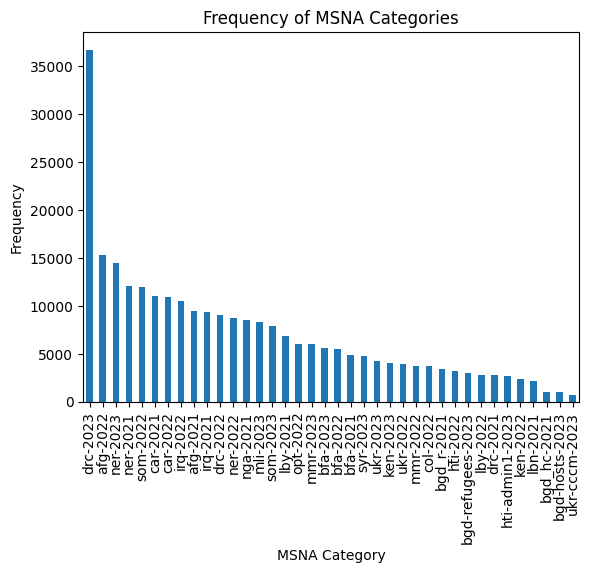

In [34]:
import missingno as msno
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr, spearmanr, kendalltau, skew
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd

# Load the CSV file into a DataFrame with low_memory=False to avoid DtypeWarning
data = pd.read_csv('msna_data.csv', low_memory=False)

# Show the number of rows and columns of the data
print("Number of rows and columns in the data:", data.shape)

# Filter out rows with missing values in the 'child_sep_severity' column
data = data.dropna(subset=['child_sep_severity'])

# Label encode any categorical variables to ensure no NaNs during conversion (just for the sake of data exploration)
label_encoder = LabelEncoder()

# Apply label encoding to categorical columns before converting them to numeric
def encode_categorical_columns(df):
    for col in df.select_dtypes(include=['object', 'category']).columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))
    return df

# Apply encoding to categorical columns
encoded_data = encode_categorical_columns(data.copy())

# Now convert to numeric (this step will not introduce NaNs because categorical columns are now encoded)
numeric_data = encoded_data.apply(pd.to_numeric, errors='coerce')

# Function to calculate correlations, p-values, and other explanatory metrics
def explanatory_analysis(df, target):
    variables = df.columns[df.columns != target]
    results = {
        'Variable': [],
        'Pearson Correlation': [],
        'Pearson P-Value': [],
        'Spearman Correlation': [],
        'Spearman P-Value': [],
        'Kendall Tau Correlation': [],
        'Kendall P-Value': [],
        'Skewness': [],
        'Variance Inflation Factor (VIF)': []
    }

    for col in variables:
        clean_df = df[[col, target]].dropna()

        # Check if the column has enough variability (at least 2 unique values)
        if len(clean_df) >= 2 and clean_df[col].nunique() > 1 and clean_df[target].nunique() > 1:
            # Pearson correlation and p-value
            pearson_corr, pearson_p = pearsonr(clean_df[col], clean_df[target])

            # Spearman correlation and p-value (only if there's variability)
            spearman_corr, spearman_p = spearmanr(clean_df[col], clean_df[target]) if clean_df[col].nunique() > 1 else (np.nan, np.nan)

            # Kendall's Tau correlation and p-value (only if there's variability)
            kendall_corr, kendall_p = kendalltau(clean_df[col], clean_df[target]) if clean_df[col].nunique() > 1 else (np.nan, np.nan)

            # Skewness (calculate only if variability exists)
            skewness = skew(clean_df[col]) if clean_df[col].nunique() > 1 else np.nan

            # VIF calculation (handled similarly)
            try:
                vif = variance_inflation_factor(df.dropna().values, df.columns.get_loc(col))
            except:
                vif = np.nan  # Handle cases where VIF cannot be computed

            # Append results to the appropriate lists
            results['Variable'].append(col)
            results['Pearson Correlation'].append(pearson_corr)
            results['Pearson P-Value'].append(pearson_p)
            results['Spearman Correlation'].append(spearman_corr)
            results['Spearman P-Value'].append(spearman_p)
            results['Kendall Tau Correlation'].append(kendall_corr)
            results['Kendall P-Value'].append(kendall_p)
            results['Skewness'].append(skewness)
            results['Variance Inflation Factor (VIF)'].append(vif)

    # Return the results as a DataFrame
    return pd.DataFrame(results).sort_values(by='Pearson Correlation', ascending=False)

# Apply the function for explanatory analysis on all numeric variables
explanatory_table = explanatory_analysis(numeric_data, 'child_sep_severity_family_reun_required')

# Print the explanatory analysis table
print(explanatory_table)

# Export the DataFrame to an Excel file
explanatory_table.to_excel("eda_corr_table.xlsx", index=False)

# Check the frequency of each category in 'msna'
msna_freq = data['msna'].value_counts()

# Print the frequency of each category in msna
print("Frequency of each category in 'msna':")
print(msna_freq)

# Visualize the distribution of msna categories
msna_freq.plot(kind='bar')
plt.title('Frequency of MSNA Categories')
plt.xlabel('MSNA Category')
plt.ylabel('Frequency')
plt.show()

# Save the loaded data as pickle file
data.to_pickle('data_raw.pkl')


## 2. Data Splitting

This script processes a dataset containing normal cases (Class 0) and anomalies (Class 1). The aim is to prepare the data for machine learning by splitting it into training, validation, and test sets, followed by separating features (X) and the target variable (y).

**Steps:**

1. **Loading the Data**:
   - The dataset is loaded from a pickle file (`data_raw.pkl`), and the target column is identified as `child_sep_severity_family_reun_required`.

2. **Splitting Data into Normal and Anomalous Classes**:
   - The data is divided into two groups: normal cases (Class 0) and anomalies (Class 1).

3. **Splitting Class 0 (Normal Cases) Data**:
   - The normal data (Class 0) is split into training (80%), validation (10%), and test (10%) sets.
   
4. **Splitting Class 1 (Anomalous Cases) Data**:
   - Since anomalies are not used for training, they are split evenly into validation and test sets.

5. **Combining Class 0 and Class 1 for Validation and Test Sets**:
   - The validation and test sets are created by combining normal and anomalous cases.

6. **Separating Features (X) and Target Variable (y)**:
   - Features (`X_train`, `X_val`, `X_test`) and the target variable (`y_train`, `y_val`, `y_test`) are separated for all splits.

7. **Saving the Data**:
   - The feature and target sets for training, validation, and test data are saved as pickle files for later use.


In [35]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the raw data
with open('data_raw.pkl', 'rb') as f:
    data = pickle.load(f)

# Define the target column
target_column = 'child_sep_severity_family_reun_required'

### 1. Separate the Data into Class 0 (Normal) and Class 1 (Anomalies) ###
# Create DataFrames for class 0 (normal cases) and class 1 (anomalies)
data_class0 = data[data[target_column] == 0]  # DataFrame for class 0
data_class1 = data[data[target_column] == 1]  # DataFrame for class 1

print(f"Total samples in Class 0 (Normal): {data_class0.shape[0]}")
print(f"Total samples in Class 1 (Anomalies): {data_class1.shape[0]}")

### 2. Split Class 0 Data into Training, Validation, and Test Sets ###
# Split class 0 data into training (80%) and temporary set (20%)
train_class0, temp_class0 = train_test_split(data_class0, test_size=0.2, random_state=42)

# Further split the temporary class 0 data into validation (10%) and test (10%) sets
val_class0, test_class0 = train_test_split(temp_class0, test_size=0.5, random_state=42)

print("\nClass 0 Data Splits:")
print(f"  Training samples: {train_class0.shape[0]}")
print(f"  Validation samples: {val_class0.shape[0]}")
print(f"  Test samples: {test_class0.shape[0]}")

### 3. Split Class 1 Data (Anomalies) into Validation and Test Sets ###
# Since we don't use anomalies for training, split class 1 data into validation and test sets
val_class1, test_class1 = train_test_split(data_class1, test_size=0.5, random_state=42)

print("\nClass 1 Data Splits (Anomalies):")
print(f"  Validation samples: {val_class1.shape[0]}")
print(f"  Test samples: {test_class1.shape[0]}")

### 4. Combine Class 0 and Class 1 Data for Validation and Test Sets ###
# Validation Set: Combine class 0 and class 1 validation data
val_data = pd.concat([val_class0, val_class1])

# Test Set: Combine class 0 and class 1 test data
test_data = pd.concat([test_class0, test_class1])

# Ensure the indices are aligned
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

### 5. Set Training Data (Only Class 0) ###
# Training set contains only class 0 (normal cases)
train_data = train_class0

# Ensure indices are aligned for consistency
train_data.reset_index(drop=True, inplace=True)

### 6. Split into X (features) and y (target) for Training, Validation, and Test Sets ###
# Training set
X_train = train_data.drop(columns=[target_column])
y_train = train_data[target_column]

# Validation set
X_val = val_data.drop(columns=[target_column])
y_val = val_data[target_column]

# Test set
X_test = test_data.drop(columns=[target_column])
y_test = test_data[target_column]

# Save the features and target for training, validation, and test sets as pickle files
with open('X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('X_val.pkl', 'wb') as f:
    pickle.dump(X_val, f)
with open('y_val.pkl', 'wb') as f:
    pickle.dump(y_val, f)
with open('X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)
with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

### 7. Print the Structure of the Resulting Splits ###
print("\nTraining Set (Only Class 0 - Normal Cases)")
print(f"  Features: {X_train.shape[1]}")
print(f"  Samples: {X_train.shape[0]}")
print(f"  Class 0: {np.sum(y_train == 0)}")
print(f"  Class 1: {np.sum(y_train == 1)}")  # Should be 0

print("\nValidation Set (Class 0 and Class 1)")
print(f"  Features: {X_val.shape[1]}")
print(f"  Samples: {X_val.shape[0]}")
print(f"  Class 0: {np.sum(y_val == 0)}")
print(f"  Class 1: {np.sum(y_val == 1)}")

print("\nTest Set (Class 0 and Class 1)")
print(f"  Features: {X_test.shape[1]}")
print(f"  Samples: {X_test.shape[0]}")
print(f"  Class 0: {np.sum(y_test == 0)}")
print(f"  Class 1: {np.sum(y_test == 1)}")



Total samples in Class 0 (Normal): 267709
Total samples in Class 1 (Anomalies): 802

Class 0 Data Splits:
  Training samples: 214167
  Validation samples: 26771
  Test samples: 26771

Class 1 Data Splits (Anomalies):
  Validation samples: 401
  Test samples: 401

Training Set (Only Class 0 - Normal Cases)
  Features: 198
  Samples: 214167
  Class 0: 214167
  Class 1: 0

Validation Set (Class 0 and Class 1)
  Features: 198
  Samples: 27172
  Class 0: 26771
  Class 1: 401

Test Set (Class 0 and Class 1)
  Features: 198
  Samples: 27172
  Class 0: 26771
  Class 1: 401


## 3. Data Cleaning

This script performs data cleaning on training, validation, and test sets by removing columns with excessive missing values, zero variance, and irrelevant suffixes, preparing the feature sets (`X`) for model training.

**Steps:**

1. **Loading Data**:
   - The feature sets (`X_train`, `X_val`, `X_test`) and target sets (`y_train`, `y_val`, `y_test`) are loaded from pickle files.
   - A list of relevant variables is loaded from a CSV file (`vars_analysis.csv`), and only these variables are retained in the datasets.

2. **Detecting Columns to Drop**:
   - **Missing Values**: Columns with more than 20% missing values are identified and marked for removal.
   - **Zero Variance**: Columns with zero variance (those with only one unique value) are detected and flagged for removal.
   - **'_NA' Suffix**: Columns ending with '_NA' are identified as irrelevant and marked for deletion.

3. **Dropping the Detected Columns**:
   - Columns identified in the previous step are dropped from the feature sets (`X_train`, `X_val`, and `X_test`).
   - The script prints the dimensions of the datasets before and after the cleaning process to track the changes.

4. **Visualizing Missing Data**:
   - The missing data matrix is visualized for the cleaned training, validation, and test sets using `missingno`, providing a graphical representation of missing values.

5. **Saving the Cleaned Data**:
   - The cleaned feature sets (`X_train_cleaned`, `X_val_cleaned`, `X_test_cleaned`) are saved as pickle files for future use.
   - The target sets (`y_train`, `y_val`, `y_test`) are saved separately and remain unaffected by the cleaning process.



Detected columns to drop:
['displ_status_specific_idp_returnee', 'received_assistance_12m_yes', 'events_6m', 'received_assistance_12m_dwta', 'wgq_dis_4_n', 'lcsi_cat', 'fatalities_1y', 'received_assistance_3m_dnk', 'received_assistance_6m_yes', 'hoh_age', 'displ_status_specific_idp_site', 'received_assistance_3m_yes', 'events_1y', 'events_3m', 'displ_status_specific_idp_non_site', 'fsl_fc_cell', 'received_assistance_6m_dwta', 'received_assistance_3m_dwta', 'fatalities_3m', 'received_assistance_6m_dnk', 'rcsi_score', 'fatalities_6m', 'wgq_dis_2_n', 'wgq_dis_3_n', 'received_assistance_12m_dnk']
Number of rows and columns in X_train: (214167, 38)
Number of rows and columns in X_val: (27172, 38)
Number of rows and columns in X_test: (27172, 38)

Number of rows and columns in X_train_cleaned: (214167, 13)
Number of rows and columns in X_val_cleaned: (27172, 13)
Number of rows and columns in X_test_cleaned: (27172, 13)

Training set after dropping columns with too many NAs and zero variance

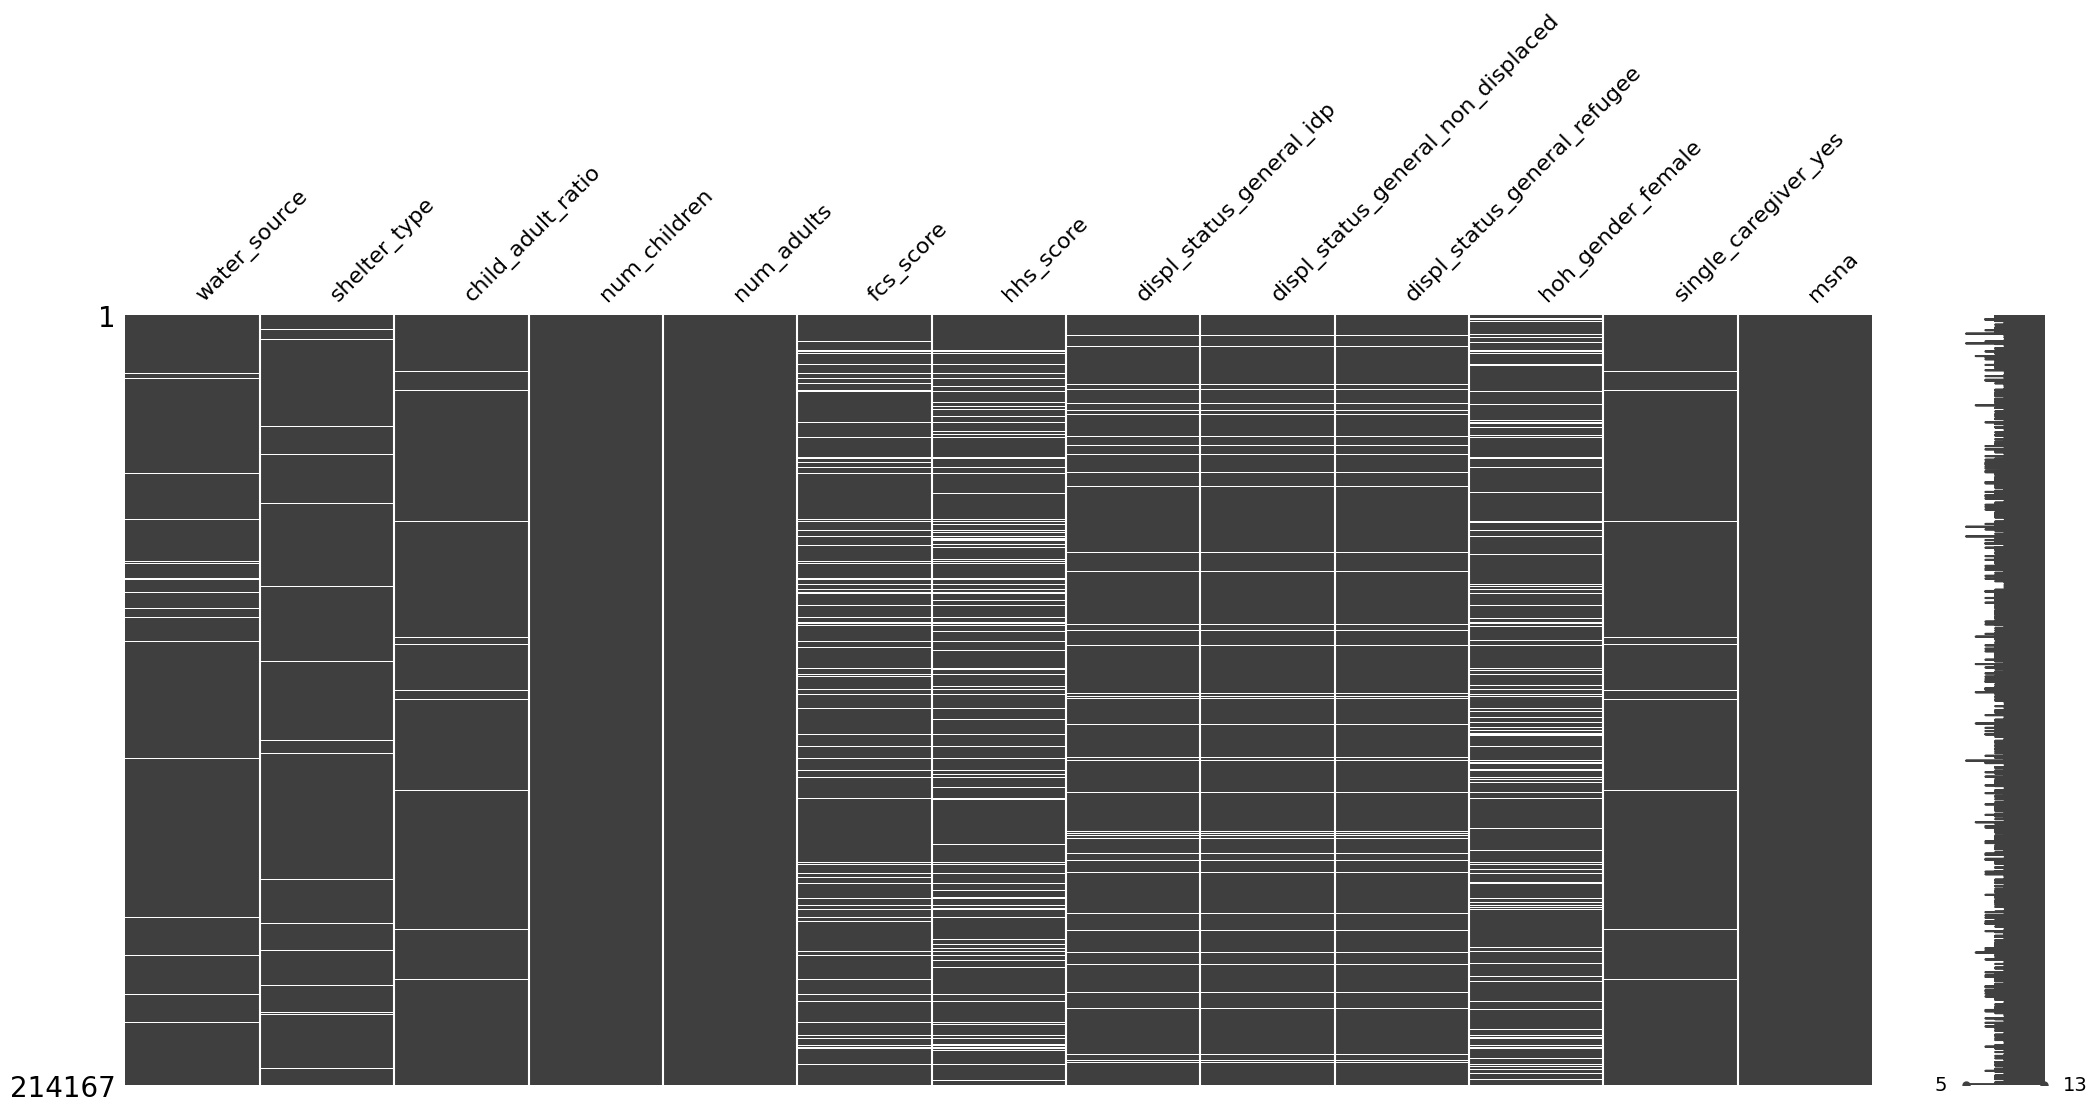


Validation set after dropping columns:


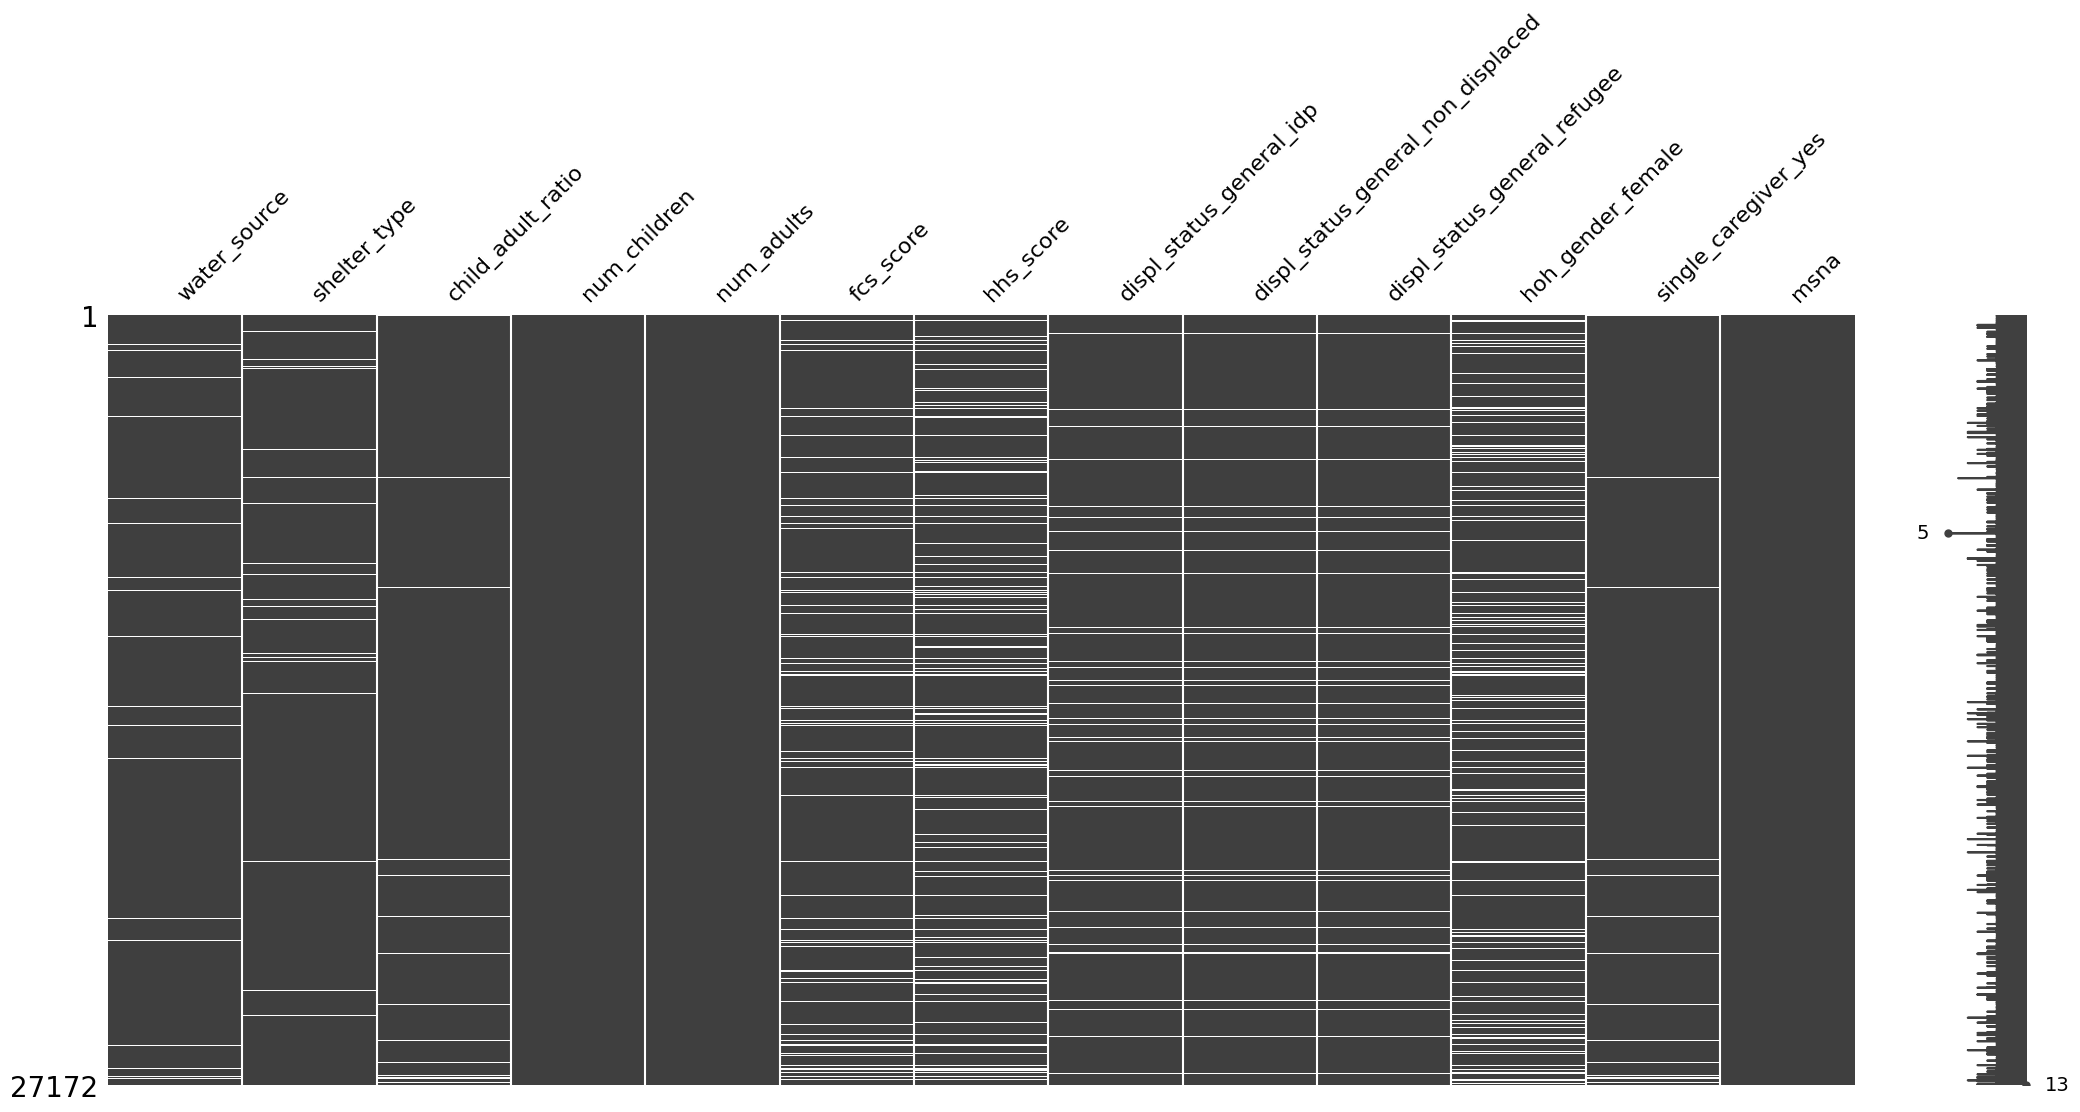


Test set after dropping columns:


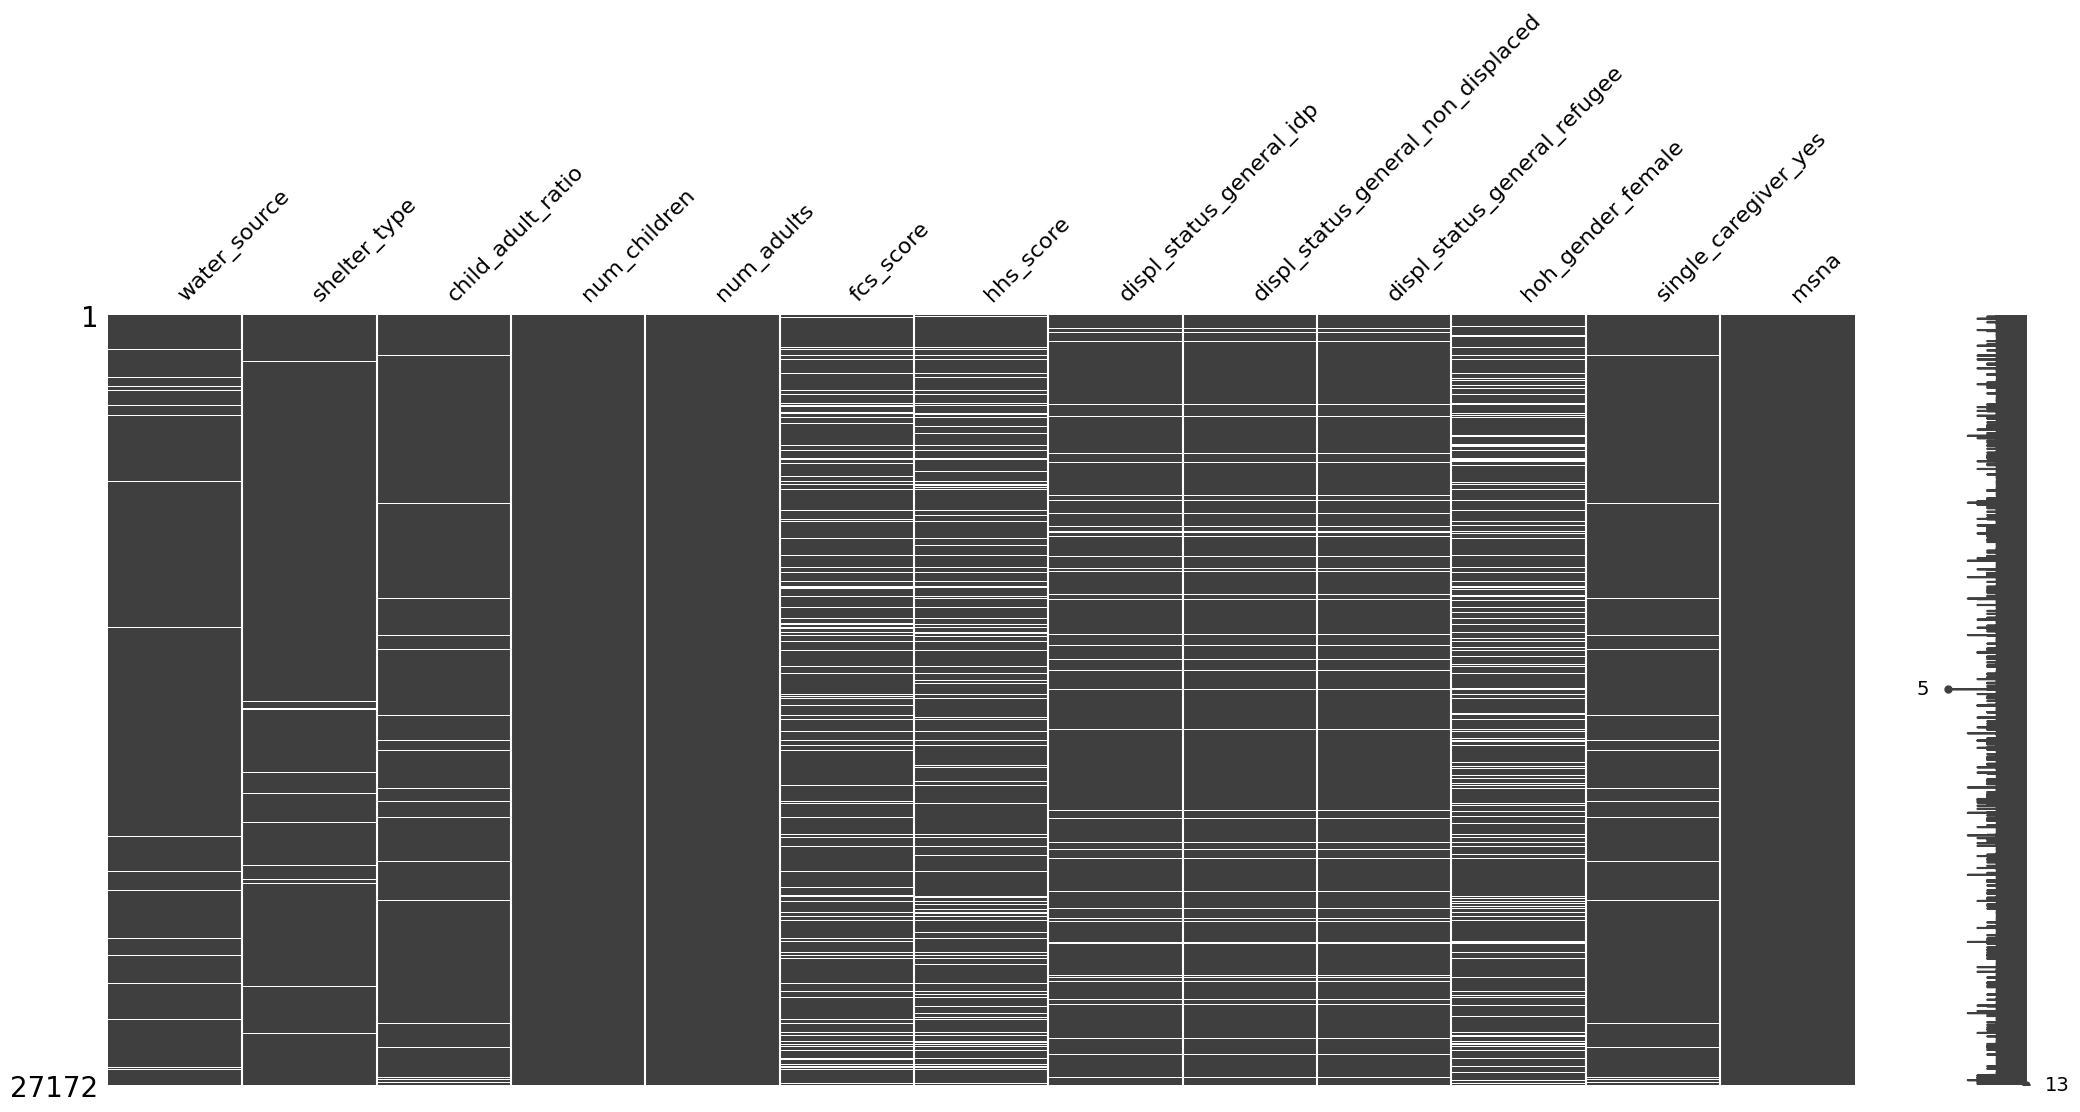

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import pickle

# Load the X (features) and y (target) sets for training, validation, and test sets
with open('X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('X_val.pkl', 'rb') as f:
    X_val = pickle.load(f)
with open('y_val.pkl', 'rb') as f:
    y_val = pickle.load(f)
with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

# Load the list of variables to consider for the model (features only)
vars_analysis = pd.read_csv('vars_analysis.csv')['variable'].tolist()
vars_analysis = [var for var in vars_analysis if var in X_train.columns]

# Exclude irrelevant columns by keeping only relevant features (X) in the datasets
X_train = X_train[vars_analysis].copy()
X_val = X_val[vars_analysis].copy()
X_test = X_test[vars_analysis].copy()

### Step 1: Detect columns to drop (more than 20% missing values, zero variance, columns ending with '_NA') ###

# Identify columns with more than 20% missing values
missing_percentage = X_train.isnull().mean() * 100
columns_with_many_missing = missing_percentage[missing_percentage > 20].index.tolist()

# Identify columns with zero variance
zero_variance_columns = X_train.nunique()
columns_with_zero_variance = zero_variance_columns[zero_variance_columns <= 1].index.tolist()

# Identify columns ending with '_NA'
na_columns = [col for col in X_train.columns if col.endswith('_NA')]

### Combine all detected columns to drop ###
columns_to_drop = list(set(columns_with_many_missing + columns_with_zero_variance + na_columns))

# Print all detected columns to drop
print("\nDetected columns to drop:")
print(columns_to_drop)

### Step 2: Drop the detected columns ###

# Drop columns from the X datasets (features only)
X_train_cleaned = X_train.drop(columns=columns_to_drop, errors='ignore')
X_val_cleaned = X_val.drop(columns=columns_to_drop, errors='ignore')
X_test_cleaned = X_test.drop(columns=columns_to_drop, errors='ignore')

# Show the number of rows and columns for each dataset before cleaning
print("Number of rows and columns in X_train:", X_train.shape)
print("Number of rows and columns in X_val:", X_val.shape)
print("Number of rows and columns in X_test:", X_test.shape)

# Show the number of rows and columns for each dataset after cleaning
print("\nNumber of rows and columns in X_train_cleaned:", X_train_cleaned.shape)
print("Number of rows and columns in X_val_cleaned:", X_val_cleaned.shape)
print("Number of rows and columns in X_test_cleaned:", X_test_cleaned.shape)

# Visualize the remaining missing data in the cleaned training set
print("\nTraining set after dropping columns with too many NAs and zero variance:")
msno.matrix(X_train_cleaned)
plt.show()

# Ensure that indices are reset for consistency in validation and test sets
X_val_cleaned.reset_index(drop=True, inplace=True)
X_test_cleaned.reset_index(drop=True, inplace=True)

# Visualize the missing data in the validation and test sets
print("\nValidation set after dropping columns:")
msno.matrix(X_val_cleaned)
plt.show()

print("\nTest set after dropping columns:")
msno.matrix(X_test_cleaned)
plt.show()

### Step 3: Save the cleaned data for X (features) and retain y (target) ###
with open('X_train_cleaned.pkl', 'wb') as f:
    pickle.dump(X_train_cleaned, f)
with open('X_val_cleaned.pkl', 'wb') as f:
    pickle.dump(X_val_cleaned, f)
with open('X_test_cleaned.pkl', 'wb') as f:
    pickle.dump(X_test_cleaned, f)

# Ensure y (target) is saved separately and remains unaffected by the cleaning process
with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('y_val.pkl', 'wb') as f:
    pickle.dump(y_val, f)
with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)


## 4. Feature Engineering 

This script performs feature engineering on training, validation, and test datasets by applying label encoding, log transformations, and creating a new variable based on the `msna` category. It ensures consistency across all datasets and excludes irrelevant variables before saving the transformed data.

**Steps:**

1. **Loading Data**:
   - The cleaned training, validation, and test datasets (`X_train_cleaned`, `X_val_cleaned`, `X_test_cleaned`) along with target sets (`y_train`, `y_val`, `y_test`) are loaded from pickle files.

2. **Loading New Labels**:
   - A CSV file (`new_labels.csv`) is loaded, containing old and new labels for specific variables. These labels are then filtered to match the columns present in the training data.

3. **Applying Label Mapping**:
   - Label encoding is applied to relevant variables in the training dataset. The labels are mapped from old to new values as specified in the CSV file.

4. **Log Transformations**:
   - Specific variables (e.g., `fcs_score`, `hhs_score`) undergo log transformations to handle skewed distributions, adding a small constant to avoid log of zero.

5. **Creating a New Variable**:
   - A new variable `msna_car_2021` is created in the datasets, encoding 1 if the `msna` category equals "car-2021" and 0 otherwise.

6. **Applying the Same Transformations to Validation and Test Sets**:
   - The same label mapping, log transformations, and creation of the `msna_car_2021` variable are applied to the validation and test datasets to maintain consistency.

7. **Ensuring Consistent Columns Across Datasets**:
   - The script ensures that the training, validation, and test datasets have the same columns by intersecting the columns of the three datasets. The `msna` variable is excluded from all datasets.

8. **Saving the Transformed Datasets**:
   - The transformed datasets (`X_fe_train`, `X_fe_val`, `X_fe_test`) are saved as pickle files for future use.


In [37]:
import pandas as pd
import pickle

# Load the cleaned training, validation, and test datasets produced from the previous cleaning step
with open('X_train_cleaned.pkl', 'rb') as f:
    X_train_cleaned = pickle.load(f)
with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('X_val_cleaned.pkl', 'rb') as f:
    X_val_cleaned = pickle.load(f)
with open('y_val.pkl', 'rb') as f:
    y_val = pickle.load(f)
with open('X_test_cleaned.pkl', 'rb') as f:
    X_test_cleaned = pickle.load(f)
with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

# Load the new_labels CSV file and filter for variables present in the training data
new_labels = pd.read_csv('new_labels.csv', usecols=['variable', 'label_old', 'label_new'])
new_labels = new_labels[new_labels['variable'].isin(X_train_cleaned.columns)]

# Print old and new labels after relabeling
print("\nOld and New Labels after Relabeling:")
print(new_labels)

# Apply label mapping to the training data
X_fe_train = X_train_cleaned.copy()

for _, row in new_labels.iterrows():
    variable = row['variable']
    label_old = row['label_old']
    label_new = int(row['label_new'])  # Convert label_new to integer
    
    if variable in X_fe_train.columns:
        X_fe_train[variable] = X_fe_train[variable].replace(label_old, label_new)

# Define recoded_variables
recoded_variables = new_labels['variable'].unique()

# Convert the recoded variables to integer type
for variable in recoded_variables:
    if variable in X_fe_train.columns:
        X_fe_train[variable] = X_fe_train[variable].fillna(pd.NA).astype('Int64')

# Apply log transformation to specific variables in the training data if they exist in the dataset
log_transform_vars = ['fcs_score', 'hhs_score', 'rcsi_score', 'fsl_fc_cell']

for var in log_transform_vars:
    if var in X_fe_train.columns:
        # Log transform the variable, adding a small constant (1) to avoid log(0)
        X_fe_train[f'{var}_log'] = np.log(X_fe_train[var] + 1)

# Create the variable 'msna_car_2021' in the training dataset
X_fe_train['msna_car_2021'] = (X_fe_train['msna'] == 'car-2021').astype(int)

# Apply the same transformations to the validation and test datasets
X_fe_val = X_val_cleaned.copy()
X_fe_test = X_test_cleaned.copy()

# Apply label mapping and log transformations to validation and test sets
for _, row in new_labels.iterrows():
    variable = row['variable']
    label_old = row['label_old']
    label_new = int(row['label_new'])

    if variable in X_fe_val.columns:
        X_fe_val[variable] = X_fe_val[variable].replace(label_old, label_new)
    
    if variable in X_fe_test.columns:
        X_fe_test[variable] = X_fe_test[variable].replace(label_old, label_new)

# Apply log transformations to validation and test datasets
for var in log_transform_vars:
    if var in X_fe_val.columns:
        X_fe_val[f'{var}_log'] = np.log(X_fe_val[var] + 1)
    
    if var in X_fe_test.columns:
        X_fe_test[f'{var}_log'] = np.log(X_fe_test[var] + 1)

# Create the variable 'msna_car_2021' in validation and test datasets
X_fe_val['msna_car_2021'] = (X_fe_val['msna'] == 'car-2021').astype(int)
X_fe_test['msna_car_2021'] = (X_fe_test['msna'] == 'car-2021').astype(int)

# Ensure all three datasets (train, val, test) have the same columns
common_columns = X_fe_train.columns.intersection(X_fe_val.columns).intersection(X_fe_test.columns)
X_fe_train = X_fe_train[common_columns]
X_fe_val = X_fe_val[common_columns]
X_fe_test = X_fe_test[common_columns]

# Exclude 'msna' variable from all datasets
X_fe_train = X_fe_train.drop(columns=['msna'], errors='ignore')
X_fe_val = X_fe_val.drop(columns=['msna'], errors='ignore')
X_fe_test = X_fe_test.drop(columns=['msna'], errors='ignore')

# Step 2: Save the transformed datasets
X_fe_train.to_pickle('X_fe_train.pkl')
X_fe_val.to_pickle('X_fe_val.pkl')
X_fe_test.to_pickle('X_fe_test.pkl')

# Print the structure of each DataFrame
print("\nStructure of X_fe_train:")
print(X_fe_train.info())

print("\nStructure of X_fe_val:")
print(X_fe_val.info())

print("\nStructure of X_fe_test:")
print(X_fe_test.info())

# Output final confirmation
print("Training, validation, and test sets have been transformed and saved.")



Old and New Labels after Relabeling:
       variable      label_old  label_new
0  shelter_type       adequate          1
1  shelter_type     inadequate          2
2  shelter_type     no_shelter          3
3  water_source       improved          1
4  water_source     unimproved          2
5  water_source  surface_water          3


C:\Users\jasper.linke\AppData\Local\Temp\ipykernel_40224\1176241288.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fe_train[variable] = X_fe_train[variable].replace(label_old, label_new)
C:\Users\jasper.linke\AppData\Local\Temp\ipykernel_40224\1176241288.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_fe_val[variable] = X_fe_val[variable].replace(label_old, label_new)
C:\Users\jasper.linke\AppData\Local\Temp\ipykernel_40224\1176241288.py:70: FutureWarning: Downcasting behavior in `replace` is deprecated and will be 


Structure of X_fe_train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214167 entries, 0 to 214166
Data columns (total 15 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   water_source                        209771 non-null  Int64  
 1   shelter_type                        209247 non-null  Int64  
 2   child_adult_ratio                   210746 non-null  float64
 3   num_children                        214167 non-null  float64
 4   num_adults                          214166 non-null  float64
 5   fcs_score                           192886 non-null  float64
 6   hhs_score                           185760 non-null  float64
 7   displ_status_general_idp            203463 non-null  float64
 8   displ_status_general_non_displaced  203463 non-null  float64
 9   displ_status_general_refugee        203463 non-null  float64
 10  hoh_gender_female                   183433 non-null  float64
 11  

## 5. Imputation of Missing Values

This script performs K-Nearest Neighbors (KNN) imputation to handle missing values in the training, validation, and test datasets. After imputation, the script ensures that binary and integer variables are correctly rounded. The imputed datasets are then saved for future use.

**Steps:**

1. **Loading Data**:
   - The cleaned training, validation, and test datasets (`X_fe_train`, `X_fe_val`, `X_fe_test`) are loaded from pickle files.

2. **KNN Imputation**:
   - A custom function `knn_impute_train_test_val` is defined to apply KNN imputation on the training data and then use the trained imputer to fill missing values in the validation and test datasets. The imputation is performed using 5 nearest neighbors by default.

3. **Imputation Application**:
   - KNN imputation is applied to the training, validation, and test datasets using the function, resulting in imputed versions of the datasets (`X_train_imputed`, `X_val_imputed`, `X_test_imputed`).

4. **Identifying Binary and Integer Columns**:
   - The script identifies binary columns (with values 0/1 or similar) and integer columns from the training dataset.
   - The identified integer columns are updated to include the binary columns, ensuring no duplicates.

5. **Rounding Integer Variables**:
   - After imputation, the script ensures that the values in integer and binary columns are correctly rounded to avoid impossible values (e.g., decimals in binary columns).

6. **Visualizing Missing Data**:
   - The missing data in the training set is visualized using a matrix plot, showing where missing values were present and imputed.

7. **Saving Imputed Datasets**:
   - The imputed versions of the training, validation, and test datasets are saved as pickle files (`X_train_imputed.pkl`, `X_val_imputed.pkl`, `X_test_imputed.pkl`) for future use.


Integer columns: ['single_caregiver_yes', 'hoh_gender_female', 'msna_car_2021', 'shelter_type', 'water_source', 'displ_status_general_idp', 'displ_status_general_refugee', 'displ_status_general_non_displaced']


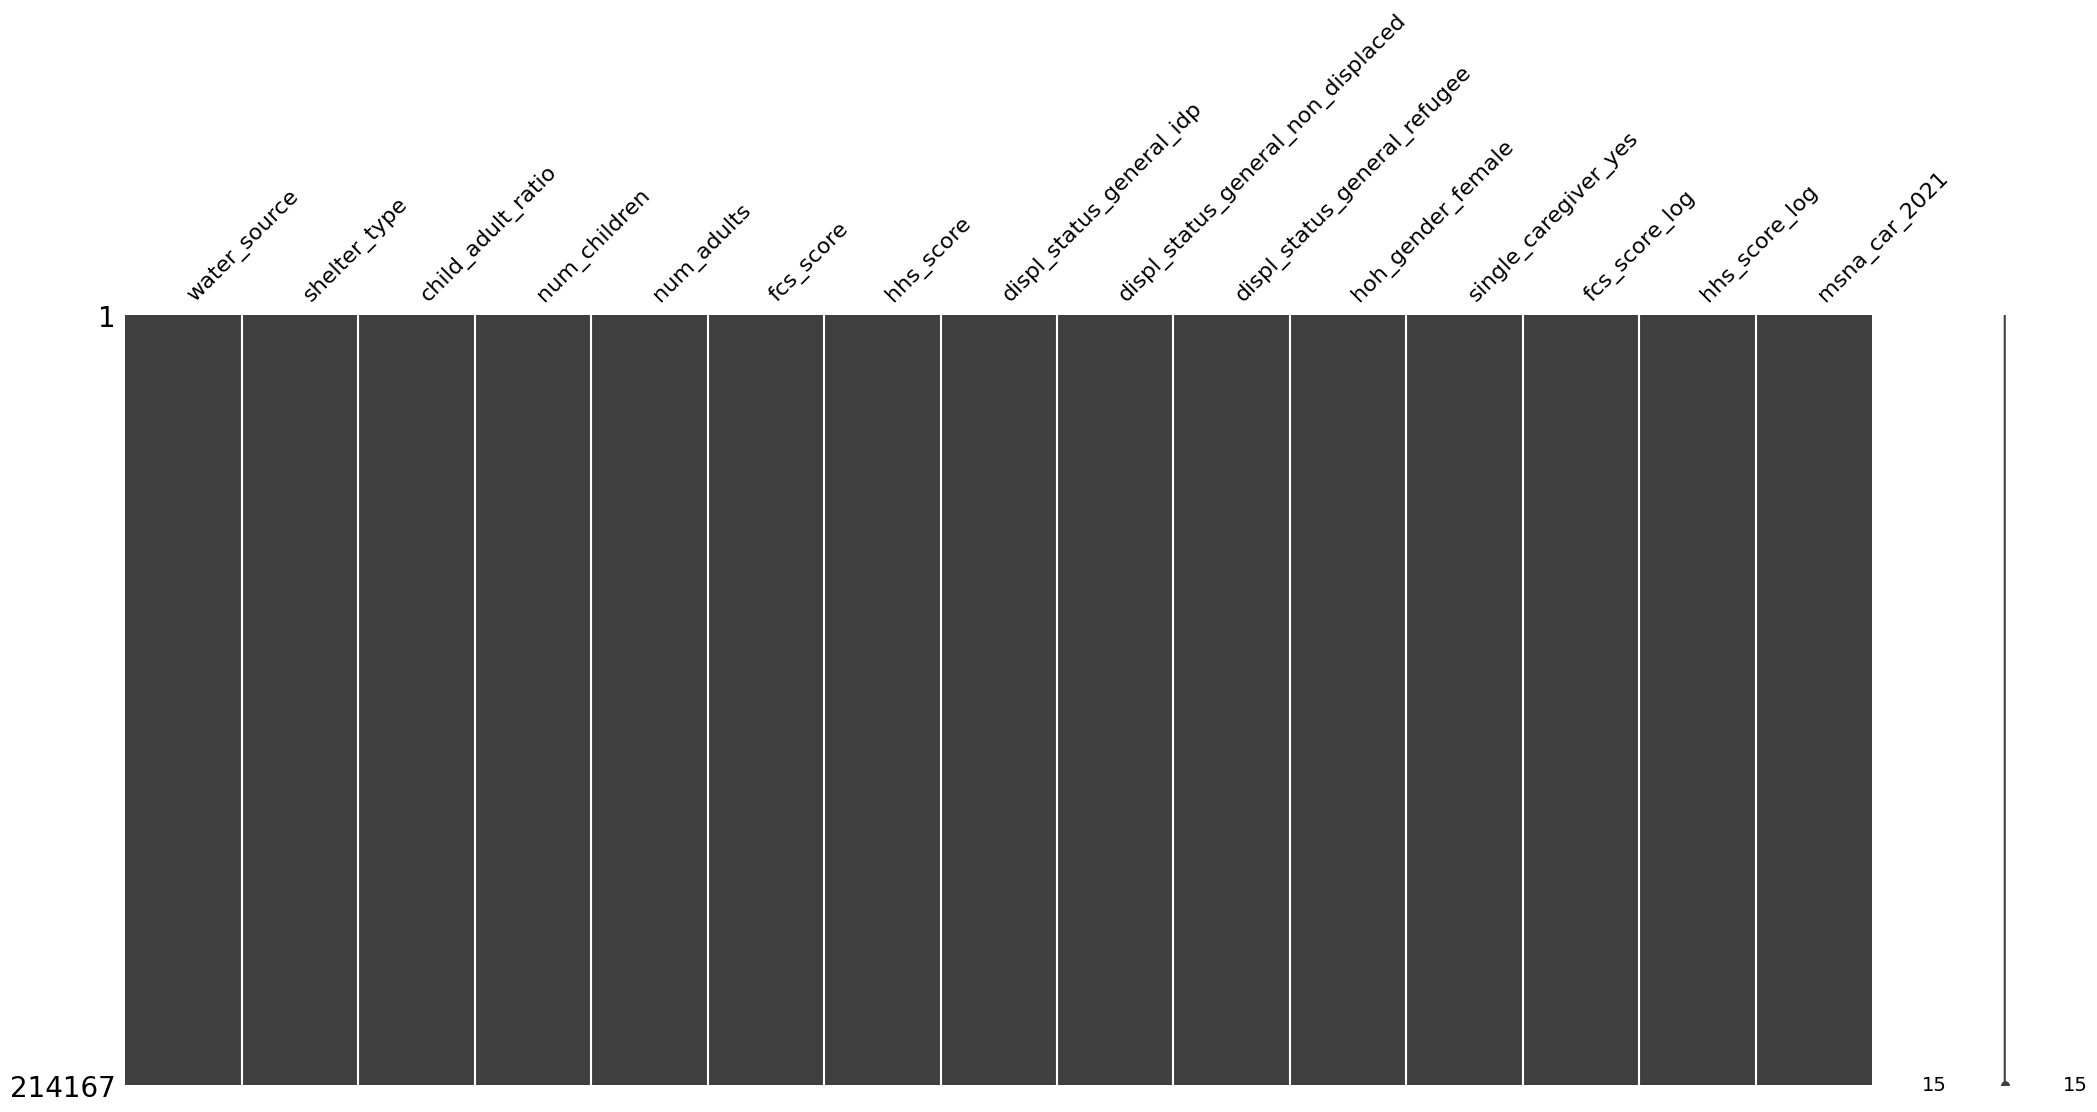


Training DataFrame with imputed values:
   water_source  shelter_type  child_adult_ratio  num_children  num_adults  \
0           1.0           1.0               5.00           5.0         1.0   
1           1.0           1.0               1.00           3.0         3.0   
2           1.0           1.0               2.50           5.0         2.0   
3           2.0           1.0               2.00           4.0         2.0   
4           1.0           1.0               0.75           3.0         4.0   

   fcs_score  hhs_score  displ_status_general_idp  \
0       20.5        0.0                       1.0   
1       40.5        3.0                       0.0   
2       39.5        3.0                       0.0   
3       19.5        1.0                       0.0   
4       33.5        2.0                       0.0   

   displ_status_general_non_displaced  displ_status_general_refugee  \
0                                 0.0                           0.0   
1                            

In [38]:
import pandas as pd
import pickle
from sklearn.impute import KNNImputer
import missingno as msno
import matplotlib.pyplot as plt

# Load the cleaned training, validation, and test datasets produced from the previous cleaning step
with open('X_fe_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('X_fe_val.pkl', 'rb') as f:
    X_val = pickle.load(f)
with open('X_fe_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

# Function to apply KNN Imputation to training set and use it on validation and test sets
def knn_impute_train_test_val(X_train, X_val, X_test, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Fit the imputer on the training data
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

    # Apply the imputer (already fit on the training data) to validation and test sets
    X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
    X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

    return X_train_imputed, X_val_imputed, X_test_imputed

# Apply KNN imputation to training, validation, and test sets
X_train_imputed, X_val_imputed, X_test_imputed = knn_impute_train_test_val(X_train, X_val, X_test)

# Identify binary columns (those with only two unique values: 0 and 1, or 1.0 and 0.0, including missing values)
binary_columns = [col for col in X_train.columns if X_train[col].dropna().nunique() == 2 and set(X_train[col].dropna().unique()).issubset({0, 1, 0.0, 1.0})]

# Identify integer columns
integer_columns = X_train.select_dtypes(include=['int64']).columns.tolist()

# Add binary columns to integer columns, ensuring no duplicates
integer_columns = list(set(integer_columns + binary_columns))

# Print the integer columns
print("Integer columns:", integer_columns)

# Ensure rounding is applied only to numeric columns that can be rounded
numeric_columns_to_round = [col for col in integer_columns if col in X_train_imputed.columns and pd.api.types.is_numeric_dtype(X_train_imputed[col])]

# Round the integer variables to ensure no impossible values are imputed
X_train_imputed[numeric_columns_to_round] = X_train_imputed[numeric_columns_to_round].round()
X_val_imputed[numeric_columns_to_round] = X_val_imputed[numeric_columns_to_round].round()
X_test_imputed[numeric_columns_to_round] = X_test_imputed[numeric_columns_to_round].round()

# Visualize missing data matrix after imputation on training set
msno.matrix(X_train_imputed)
plt.show()

# Display the first few rows of the new dataframe with imputed values
print("\nTraining DataFrame with imputed values:")
print(X_train_imputed.head())

# Save the imputed DataFrames as pickle files
with open('X_train_imputed.pkl', 'wb') as f:
    pickle.dump(X_train_imputed, f)
with open('X_val_imputed.pkl', 'wb') as f:
    pickle.dump(X_val_imputed, f)
with open('X_test_imputed.pkl', 'wb') as f:
    pickle.dump(X_test_imputed, f)


## 6. Create Interaction Terms

This script processes three datasets (`X_train_imputed`, `X_val_imputed`, `X_test_imputed`) by creating **interaction terms** between the `msna_car_2021` variable and all other numeric columns in each dataset. It then saves the modified datasets with the new interaction terms.

**Steps:**

1. **Loading Data:**
   - The script loads the imputed training, validation, and test datasets using `pandas.read_pickle()`.

2. **Creating Copies of the Datasets:**
   - Copies of the original datasets (`X_train_inter`, `X_val_inter`, and `X_test_inter`) are created to ensure the original data remains unchanged.

3. **Identifying Numeric Columns:**
   - The script identifies all numeric columns in the training dataset (`int64` and `float64` data types) to prepare for the interaction term creation.

4. **Creating Interaction Terms:**
   - For each numeric column (excluding `msna_car_2021` itself), interaction terms are created between that column and `msna_car_2021`.
   - The interaction terms are added to the training, validation, and test datasets with a new column name pattern: `column_x_msna_car_2021`.

5. **Printing the Results:**
   - The script prints the number of new interaction terms added to the training dataset.
   - It also prints the structure of the training DataFrame after adding the new interaction terms.

6. **Saving Modified Datasets:**
   - The modified datasets, which now contain the interaction terms, are saved as new pickle files (`X_train_inter.pkl`, `X_val_inter.pkl`, `X_test_inter.pkl`).


In [39]:
import pandas as pd

# Load the imputed datasets (training, validation, and test)
X_train_imputed = pd.read_pickle('X_train_imputed.pkl')
X_val_imputed = pd.read_pickle('X_val_imputed.pkl')
X_test_imputed = pd.read_pickle('X_test_imputed.pkl')

# Work with copies of the loaded data to avoid changing the originals
X_train_inter = X_train_imputed.copy()
X_val_inter = X_val_imputed.copy()
X_test_inter = X_test_imputed.copy()

# Identify numeric columns in the training set for interaction
numeric_columns = X_train_inter.select_dtypes(include=['int64', 'float64']).columns

# Create interaction terms between 'msna_cluster' and all other numeric variables in the training set
for column in numeric_columns:
    if column != 'msna_car_2021':  # Skip interaction of msna_cluster with itself
        interaction_column_name = f'{column}_x_msna_car_2021'
        
        # Interaction for the training set
        X_train_inter[interaction_column_name] = X_train_inter[column] * X_train_inter['msna_car_2021']
        
        # Apply the same interaction transformation to validation and test sets
        X_val_inter[interaction_column_name] = X_val_inter[column] * X_val_inter['msna_car_2021']
        X_test_inter[interaction_column_name] = X_test_inter[column] * X_test_inter['msna_car_2021']

# Print the number of new interaction terms added in the training set
num_new_columns = len([col for col in X_train_inter.columns if '_x_msna_car_2021' in col])
print(f"\nNumber of new interaction terms added: {num_new_columns}")

# Print the structure of the training DataFrame
print("\nStructure of the Training DataFrame after adding interaction terms:")
print(X_train_inter.info())

# Save the modified datasets with interaction terms to new pickle files
X_train_inter.to_pickle('X_train_inter.pkl')
X_val_inter.to_pickle('X_val_inter.pkl')
X_test_inter.to_pickle('X_test_inter.pkl')

# Inspect the new columns added to the modified training data
new_columns = [col for col in X_train_inter.columns if '_x_msna_car_2021' in col]
print("\nNew Columns with Interaction Terms:")
print(new_columns)

# Show the first 5 rows of the new columns with interaction terms in the training set
print("\nFirst 5 rows of the new columns with interaction terms (Training Set):")
print(X_train_inter[new_columns].head())



Number of new interaction terms added: 14

Structure of the Training DataFrame after adding interaction terms:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214167 entries, 0 to 214166
Data columns (total 29 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   water_source                                        214167 non-null  float64
 1   shelter_type                                        214167 non-null  float64
 2   child_adult_ratio                                   214167 non-null  float64
 3   num_children                                        214167 non-null  float64
 4   num_adults                                          214167 non-null  float64
 5   fcs_score                                           214167 non-null  float64
 6   hhs_score                                           214167 non-null  float64
 7   displ_status_general_idp          

## 7. Data Standardization

This script applies standardization to numerical variables in the training, validation, and test datasets. It ensures that numerical variables are scaled to have a mean of 0 and a standard deviation of 1. The standardized datasets are then saved for future use.

**Steps:**

1. **Loading Data**:
   - The training, validation, and test sets (`X_train_inter`, `X_val_inter`, `X_test_inter`) are loaded from pickle files.

2. **Identifying Numerical Variables**:
   - The script reads the `vars_analysis.csv` file to identify which variables are numerical.
   - It also identifies columns in the datasets that either contain "log" in their name or are substrings of numerical variable names.
   - The combined list of numerical variables is filtered to ensure that only those present in the data are selected.

3. **Standardization**:
   - A `StandardScaler` is used to standardize the numerical variables in the training dataset (`X_train_inter`), ensuring that they have a mean of 0 and a standard deviation of 1.
   - The same scaler is then applied to the validation and test sets to maintain consistency.

4. **Saving Standardized Data**:
   - The standardized training, validation, and test datasets are saved as pickle files (`X_train_stand.pkl`, `X_val_stand.pkl`, `X_test_stand.pkl`).

5. **Displaying Statistics**:
   - The script displays summary statistics for the numerical variables in the training dataset, both before and after standardization, to show the effect of the scaling process.

6. **Visualization**:
   - Histograms are created for a specific variable (`child_adult_ratio`) to visually compare its distribution before and after standardization in the training set.

Numerical variables to standardize:
['hhs_score_log', 'hhs_score_log_x_msna_car_2021', 'num_adults_x_msna_car_2021', 'hhs_score', 'num_children_x_msna_car_2021', 'fcs_score_log_x_msna_car_2021', 'fcs_score_x_msna_car_2021', 'fcs_score_log', 'child_adult_ratio_x_msna_car_2021', 'child_adult_ratio', 'fcs_score', 'hhs_score_x_msna_car_2021', 'num_adults', 'num_children']

Summary statistics before standardization (numerical variables only, training set):
       hhs_score_log  hhs_score_log_x_msna_car_2021  \
count  214167.000000                  214167.000000   
mean        0.545693                       0.047364   
std         0.585242                       0.247967   
min         0.000000                       0.000000   
25%         0.000000                       0.000000   
50%         0.277259                       0.000000   
75%         1.098612                       0.000000   
max         1.945910                       1.945910   

       num_adults_x_msna_car_2021      hhs_score

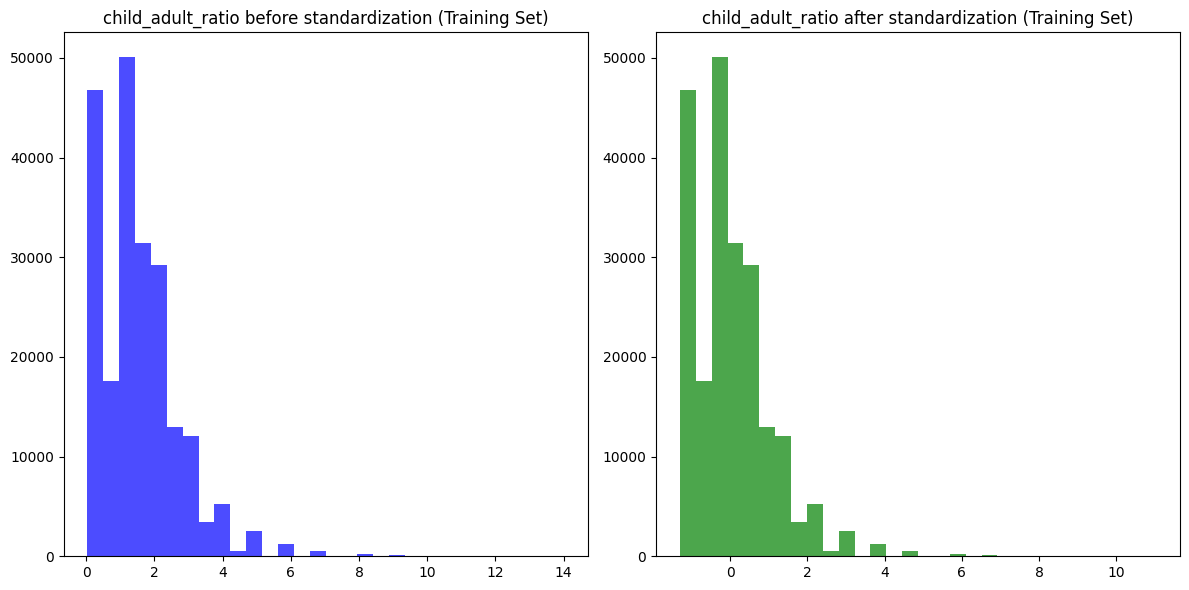

In [40]:
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the training, validation, and test sets
with open('X_train_inter.pkl', 'rb') as f:
    X_train_inter = pickle.load(f)
with open('X_val_inter.pkl', 'rb') as f:
    X_val_inter = pickle.load(f)
with open('X_test_inter.pkl', 'rb') as f:
    X_test_inter = pickle.load(f)

# Load the vars_analysis.csv to identify variable types
vars_analysis = pd.read_csv('vars_analysis.csv', usecols=['variable', 'type'])
numerical_variables = vars_analysis[vars_analysis['type'] == 'numerical']['variable'].tolist()

# Standardize the numerical variables
scaler = StandardScaler()

# Identify columns that contain "log" in their name from training data
log_columns = [col for col in X_train_inter.columns if "log" in col]

# Identify columns in training data that contain any of the numerical_variables as a substring
substring_columns = []
for var in numerical_variables:
    substring_columns.extend([col for col in X_train_inter.columns if var in col])

# Combine both lists (log_columns and substring_columns) with the initial numerical_variables, ensuring no duplicates
combined_numerical_vars = list(set(numerical_variables + log_columns + substring_columns))

# Filter numerical variables that are actually present in the DataFrames
numerical_variables = [var for var in combined_numerical_vars if var in X_train_inter.columns]

# Print the filtered numerical variables to standardize
print("Numerical variables to standardize:")
print(numerical_variables)

# Standardize the training data
X_train_stand = X_train_inter.copy()
X_train_stand[numerical_variables] = scaler.fit_transform(X_train_stand[numerical_variables])

# Apply the same standardization to the validation and test sets (using the same scaler fit on the training set)
X_val_stand = X_val_inter.copy()
X_val_stand[numerical_variables] = scaler.transform(X_val_stand[numerical_variables])

X_test_stand = X_test_inter.copy()
X_test_stand[numerical_variables] = scaler.transform(X_test_stand[numerical_variables])

# Save the standardized DataFrames as pickle files
with open('X_train_stand.pkl', 'wb') as f:
    pickle.dump(X_train_stand, f)
with open('X_val_stand.pkl', 'wb') as f:
    pickle.dump(X_val_stand, f)
with open('X_test_stand.pkl', 'wb') as f:
    pickle.dump(X_test_stand, f)

# Display summary statistics before and after standardization for the training set
print("\nSummary statistics before standardization (numerical variables only, training set):")
print(X_train_inter[numerical_variables].describe())
print("\nSummary statistics after standardization (numerical variables only, training set):")
print(X_train_stand[numerical_variables].describe())

# Display histograms before and after standardization for a specific variable
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(X_train_inter['child_adult_ratio'], bins=30, alpha=0.7, color='blue')
plt.title('child_adult_ratio before standardization (Training Set)')

plt.subplot(1, 2, 2)
plt.hist(X_train_stand['child_adult_ratio'], bins=30, alpha=0.7, color='green')
plt.title('child_adult_ratio after standardization (Training Set)')

plt.tight_layout()
plt.show()


## 8. Feature Selection

This script performs feature selection on standardized training, validation, and test datasets. It identifies and removes highly correlated features while preserving key transformed variables like log-transformed features and binary (`_yes`) columns. The selected features are then saved for future use.

**Steps:**

1. **Loading Data**:
   - The standardized training, validation, and test sets are loaded from pickle files (`X_train_stand.pkl`, `X_val_stand.pkl`, `X_test_stand.pkl`).
   - The target variable (`y_train.pkl`) is also loaded to verify the correct target column.

2. **Correlation Analysis**:
   - A correlation matrix is calculated for the training dataset.
   - The script identifies highly correlated features, with a correlation threshold set at 0.9.
   - For log-transformed columns, if the original version of the feature is highly correlated with its log-transformed counterpart, the original feature is dropped.
   - For binary (`_yes`) columns, if a column has a counterpart (`_no`) that is highly correlated, the counterpart is dropped.

3. **Removing Highly Correlated Features**:
   - The identified highly correlated features are removed from the training dataset (`X_train_fs`), and the same features are dropped from the validation and test datasets.

4. **Ensuring Consistency Across Datasets**:
   - The script ensures that the same features remain in the training, validation, and test datasets by keeping only the common columns in all three sets.

5. **Saving Selected Features**:
   - The selected features for the training, validation, and test sets are saved as pickle files (`X_train_selected.pkl`, `X_val_selected.pkl`, `X_test_selected.pkl`).


In [41]:
import pandas as pd
import numpy as np
import pickle

# Load the standardized training, validation, and test sets
with open('X_train_stand.pkl', 'rb') as f:
    X_train_stand = pickle.load(f)
with open('X_val_stand.pkl', 'rb') as f:
    X_val_stand = pickle.load(f)
with open('X_test_stand.pkl', 'rb') as f:
    X_test_stand = pickle.load(f)
with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

# Copy the training data for feature selection
X_train_fs = X_train_stand.copy()

# Separate features and target variable
target_column = 'child_sep_severity_family_reun_required'
if target_column not in y_train.name:
    raise KeyError(f"Target column '{target_column}' not found in the target variable.")

# Ensure input data is correct (numeric, no missing values)
def check_numeric(df):
    non_numeric = df.columns[~df.dtypes.apply(lambda x: np.issubdtype(x, np.number))]
    if len(non_numeric) > 0:
        raise ValueError(f"Non-numeric columns detected: {list(non_numeric)}. Please convert them to numeric format.")

def check_no_missing(df):
    missing = df.columns[df.isnull().any()]
    if len(missing) > 0:
        raise ValueError(f"Missing values found in columns: {list(missing)}. Please handle missing data before proceeding.")

check_numeric(X_train_fs)
check_no_missing(X_train_fs)

# Identify log-transformed and _yes columns
log_columns = [col for col in X_train_fs.columns if col.endswith('_log')]
yes_columns = [col for col in X_train_fs.columns if col.endswith('_yes')]

# Correlation Analysis to remove highly correlated features, but keep "_log", "_yes" versions
corr_matrix = X_train_fs.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

correlation_threshold = 0.9  # Adjust if needed
to_drop = []

# Go through each log-transformed column and check correlation with its original counterpart
for log_col in log_columns:
    original_col = log_col.replace('_log', '')
    if original_col in X_train_fs.columns:
        if corr_matrix.loc[log_col, original_col] > correlation_threshold:
            to_drop.append(original_col)

# Go through each _yes column and check correlation with its _no counterpart
for yes_col in yes_columns:
    no_col = yes_col.replace('_yes', '_no')
    if no_col in X_train_fs.columns:
        if corr_matrix.loc[yes_col, no_col] > correlation_threshold:
            to_drop.append(no_col)

# Drop the identified columns, ensuring no duplicates
to_drop = list(set(to_drop))
X_train_uncorr = X_train_fs.drop(columns=to_drop)

if to_drop:
    print(f"\nDropping {len(to_drop)} highly correlated features: {to_drop}")
else:
    print("\nNo highly correlated features found to drop.")

# Ensure enough features remain after removing correlated ones
if X_train_uncorr.shape[1] == 0:
    raise ValueError("No features remaining after removing highly correlated ones.")

# Apply the same feature selection to validation and test sets
X_val_uncorr = X_val_stand.drop(columns=to_drop, errors='ignore')
X_test_uncorr = X_test_stand.drop(columns=to_drop, errors='ignore')

# Ensure the same features remain in all sets
common_columns = X_train_uncorr.columns.intersection(X_val_uncorr.columns).intersection(X_test_uncorr.columns)
X_train_selected = X_train_uncorr[common_columns]
X_val_selected = X_val_uncorr[common_columns]
X_test_selected = X_test_uncorr[common_columns]

# Save the selected features for training, validation, and test sets
X_train_selected.to_pickle('X_train_selected.pkl')
X_val_selected.to_pickle('X_val_selected.pkl')
X_test_selected.to_pickle('X_test_selected.pkl')

# Print the first few rows of the selected data
print("\nSelected features in the training set:")
print(X_train_selected.head())



Dropping 2 highly correlated features: ['fcs_score', 'hhs_score']

Selected features in the training set:
   water_source  shelter_type  child_adult_ratio  num_children  num_adults  \
0           1.0           1.0           3.081601      0.779375   -1.160684   
1           1.0           1.0          -0.451556     -0.183301    0.184737   
2           1.0           1.0           0.873378      0.779375   -0.487974   
3           2.0           1.0           0.431734      0.298037   -0.487974   
4           1.0           1.0          -0.672378     -0.183301    0.857447   

   displ_status_general_idp  displ_status_general_non_displaced  \
0                       1.0                                 0.0   
1                       0.0                                 1.0   
2                       0.0                                 1.0   
3                       0.0                                 0.0   
4                       0.0                                 0.0   

   displ_status_gener

## 9. Model Training

This script performs anomaly detection model training using **One-Class SVM**, **Isolation Forest**, and a **Stacked Model** approach. It employs hyperparameter tuning techniques, such as **RandomizedSearchCV** and **HalvingRandomSearchCV**, to optimize the models. The best-performing models are saved for future use.

### **Steps:**

1. **Hyperparameter Grids**:
   - The script defines expanded hyperparameter grids for both **One-Class SVM** and **Isolation Forest** to improve model robustness.
   - **One-Class SVM** focuses on the 'rbf' kernel with exploration of parameters like `nu` and `gamma`.
   - **Isolation Forest** explores parameters such as `n_estimators`, `max_samples`, `contamination`, and the `bootstrap` option to improve performance.

2. **Custom Scoring Function**:
   - A custom scoring function, **negative mean squared error (neg MSE)**, is used for evaluating model performance during hyperparameter tuning.
   - This function calculates the difference between actual data and the decision or anomaly scores to evaluate the model.

3. **Loading Training Data**:
   - The training data, which contains only the normal class (Class 0), is loaded from a pickle file (`X_train_selected.pkl`).
   - The training data is checked and aligned to ensure the proper column structure with feature names.

4. **Training One-Class SVM**:
   - The **One-Class SVM** model is trained using **RandomizedSearchCV** for hyperparameter optimization.
   - The search process evaluates the performance of different hyperparameter configurations using the neg MSE scorer, and the model is retrained using the best hyperparameters found.

5. **Training Isolation Forest**:
   - The **Isolation Forest** model is trained using **HalvingRandomSearchCV**, which efficiently explores hyperparameter configurations by progressively narrowing down the search space.
   - The same custom neg MSE scorer is used, and the best model is retrained with optimal hyperparameters.

6. **Training the Stacked Model**:
   - A **Stacked Model** is trained by combining the anomaly scores from the **One-Class SVM** and **Isolation Forest** models.
   - The base models are trained on part of the training data, and their anomaly scores are used to create meta-features for the stacked model.
   - The stacked model is trained using these meta-features to enhance anomaly detection performance.

7. **Saving the Models**:
   - The best-performing **One-Class SVM**, **Isolation Forest**, and **Stacked Model** are saved as a pickle file (`trained_models.pkl`) for later use in evaluation and deployment.



In [42]:
import pickle
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import RandomizedSearchCV, HalvingRandomSearchCV, train_test_split
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.base import clone
import numpy as np
import pandas as pd  # Import pandas to work with DataFrames

# Expanded hyperparameter grids for more robust tuning
param_grid_ocsvm = {
    'kernel': ['rbf'],
    'nu': [0.01, 0.05, 0.1],
    'gamma': ['scale', 'auto']
}

param_grid_isolation_forest = {
    'n_estimators': [50, 100, 200, 300],
    'max_samples': [0.6, 0.8, 1.0],
    'contamination': [0.01, 0.05, 0.1],
    'bootstrap': [False, True]
}

# Custom scoring function for training on normal data
def neg_mse_scorer(estimator, X):
    if hasattr(estimator, 'decision_function'):
        scores = estimator.decision_function(X)
    else:
        scores = estimator.score_samples(X)
    return -mean_squared_error(np.zeros_like(scores), scores)

# Load training data (normal class only)
def load_training_data():
    with open('X_train_selected.pkl', 'rb') as f:
        X_train = pickle.load(f)
    return X_train

# Tune hyperparameters and retrain One-Class SVM
def train_ocsvm(X_train):
    ocsvm = OneClassSVM()
    randomized_search = RandomizedSearchCV(
        ocsvm, param_distributions=param_grid_ocsvm,
        cv=2, scoring=make_scorer(neg_mse_scorer),
        n_iter=10,
        verbose=1, n_jobs=-1,
        refit=False  # Do not refit automatically
    )
    randomized_search.fit(X_train)

    # Retrieve the best hyperparameters
    best_params = randomized_search.best_params_

    # Retrain the model on the full training data with feature names
    best_ocsvm = OneClassSVM(**best_params)
    best_ocsvm.fit(X_train)
    return best_ocsvm

# Tune hyperparameters and retrain Isolation Forest
def train_isolation_forest(X_train):
    iso_forest = IsolationForest(random_state=42)
    halving_search = HalvingRandomSearchCV(
        iso_forest, param_distributions=param_grid_isolation_forest,
        factor=2,
        cv=2,
        scoring=make_scorer(neg_mse_scorer),
        verbose=1, n_jobs=-1,
        refit=False  # Do not refit automatically
    )
    halving_search.fit(X_train)

    # Retrieve the best hyperparameters
    best_params = halving_search.best_params_

    # Retrain the model on the full training data with feature names
    best_iso_forest = IsolationForest(**best_params, random_state=42)
    best_iso_forest.fit(X_train)
    return best_iso_forest

# Stacking models
def train_stacked_model(X_train, best_ocsvm, best_iso_forest):
    # Split X_train into training and meta-training sets
    X_base_train, X_meta_train = train_test_split(X_train, test_size=0.3, random_state=42)

    # Clone base models to ensure they are retrained
    ocsvm = clone(best_ocsvm)
    iso_forest = clone(best_iso_forest)

    # Train base models on base training set
    ocsvm.fit(X_base_train)
    iso_forest.fit(X_base_train)

    # Generate anomaly scores on meta-training set
    ocsvm_scores = ocsvm.decision_function(X_meta_train).reshape(-1, 1)
    iso_forest_scores = iso_forest.score_samples(X_meta_train).reshape(-1, 1)

    # Stack the scores
    meta_features = np.hstack((ocsvm_scores, iso_forest_scores))

    # Train meta-model
    meta_model = OneClassSVM(kernel='rbf', gamma='auto')
    meta_model.fit(meta_features)

    return meta_model

# Save trained models
def save_trained_models(models, filename='trained_models.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(models, f)

if __name__ == '__main__':
    # Load and train models
    X_train = load_training_data()

    # Ensure X_train is a DataFrame with proper column names
    if not isinstance(X_train, pd.DataFrame):
        X_train = pd.DataFrame(X_train)

    # Check if X_train has meaningful column names
    if X_train.columns.isnull().any() or all(isinstance(col, int) for col in X_train.columns):
        # Assign default column names
        X_train.columns = [f'feature_{i}' for i in range(X_train.shape[1])]

    # Save feature names
    with open('feature_names.pkl', 'wb') as f:
        pickle.dump(X_train.columns.tolist(), f)

    # Train One-Class SVM and Isolation Forest
    best_ocsvm = train_ocsvm(X_train)
    best_iso_forest = train_isolation_forest(X_train)

    # Train stacked model
    meta_model = train_stacked_model(X_train, best_ocsvm, best_iso_forest)

    # Save the models
    save_trained_models({
        'OneClassSVM': best_ocsvm,
        'IsolationForest': best_iso_forest,
        'StackedModel': meta_model
    })


Fitting 2 folds for each of 6 candidates, totalling 12 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 16
min_resources_: 4
max_resources_: 214167
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 72
n_resources: 4
Fitting 2 folds for each of 72 candidates, totalling 144 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 72 is smaller than n_iter=53541. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
24 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 886, in _fit_and_score
    estimator.fit(X_t

----------
iter: 1
n_candidates: 36
n_resources: 8
Fitting 2 folds for each of 36 candidates, totalling 72 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan 

----------
iter: 2
n_candidates: 18
n_resources: 16
Fitting 2 folds for each of 18 candidates, totalling 36 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan 

----------
iter: 3
n_candidates: 9
n_resources: 32
Fitting 2 folds for each of 9 candidates, totalling 18 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\

----------
iter: 4
n_candidates: 5
n_resources: 64
Fitting 2 folds for each of 5 candidates, totalling 10 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

----------
iter: 5
n_candidates: 3
n_resources: 128
Fitting 2 folds for each of 3 candidates, totalling 6 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan 

----------
iter: 6
n_candidates: 2
n_resources: 256
Fitting 2 folds for each of 2 candidates, totalling 4 fits


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]
  warnings.warn(
c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan

## 10. Model Evaluation

This script is designed to evaluate trained models on a validation dataset and select the best-performing model based on the **F1-score** at the optimal threshold. The script loads pre-trained models, makes predictions on the validation set, computes performance metrics, and selects the best model for anomaly detection.

### **Steps:**

1. **Loading Trained Models**:
   - The script loads pre-trained models from the file `trained_models.pkl`.
   - Models include **One-Class SVM**, **Isolation Forest**, and optionally a **Stacked Model**, previously trained and saved for anomaly detection.

2. **Loading and Aligning Validation Data**:
   - The validation dataset (`X_val_selected.pkl` for features and `y_val.pkl` for labels) is loaded and validated to ensure the correct column structure (using `feature_names.pkl` if necessary).
   - Alignment is performed to match the structure of the training data, ensuring the correct use of feature columns.

3. **Evaluating Models**:
   - Each model is evaluated by making predictions on the validation data and computing anomaly scores:
     - **Anomaly scores** are calculated using `decision_function` for **One-Class SVM** and `score_samples` for **Isolation Forest**.
     - **Precision-Recall Curve** is computed for each model, and the **AUC (Area Under the Curve)** of the Precision-Recall curve is calculated.
   - **F1-score** is computed at different thresholds based on the Precision-Recall curve, and the threshold yielding the highest F1-score is identified as the **optimal threshold**.
   - For each model, a **classification report** is generated to provide additional metrics (precision, recall, F1-score) at the optimal threshold.
   - Models are evaluated based on their F1-score at the optimal threshold, and the model with the highest **F1-score** is selected.

4. **Evaluating the Stacked Model** (Optional):
   - If a **Stacked Model** is available, it is evaluated similarly to the individual models.
   - Anomaly scores from base models (One-Class SVM and Isolation Forest) are stacked as meta-features, and the **Stacked Model** makes predictions using these features.
   - The optimal threshold for the **Stacked Model** is determined, and its performance is compared with the individual models.

5. **Selecting and Saving the Best Model**:
   - The model with the highest **F1-score** is selected as the best model.
   - The **best-performing model**, its name, and the **optimal threshold** are saved in a pickle file (`best_model.pkl`) for further testing or deployment.



In [43]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_recall_curve, auc, f1_score
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

# Load trained models
def load_trained_models(filename='trained_models.pkl'):
    with open(filename, 'rb') as f:
        models = pickle.load(f)
    return models

# Load validation data
def load_validation_data():
    with open('X_val_selected.pkl', 'rb') as f:
        X_val = pickle.load(f)
    with open('y_val.pkl', 'rb') as f:
        y_val = pickle.load(f)
    return X_val, y_val

# Ensure validation data has the same columns as training data
def align_validation_data(X_val):
    # Ensure X_val is a DataFrame
    if not isinstance(X_val, pd.DataFrame):
        X_val = pd.DataFrame(X_val)

    # Assign column names to X_val if necessary
    if X_val.columns.isnull().any() or all(isinstance(col, int) for col in X_val.columns):
        with open('feature_names.pkl', 'rb') as f:
            feature_names = pickle.load(f)
        X_val.columns = feature_names
    return X_val

# Evaluate models and select the best one based on F1-score
def evaluate_models(models, X_val, y_val):
    best_f1 = 0
    best_model = None
    best_model_name = ''
    best_threshold = None

    # Align validation data
    X_val = align_validation_data(X_val)

    # Evaluate base models
    for model_name in ['OneClassSVM', 'IsolationForest']:
        print(f"\nEvaluating {model_name}...")
        model = models[model_name]
        X_val_aligned = X_val

        # Get anomaly scores
        if hasattr(model, 'decision_function'):
            scores = -model.decision_function(X_val_aligned)
        else:
            scores = -model.score_samples(X_val_aligned)  # For IsolationForest, invert scores

        # Compute precision-recall curve
        precision, recall, thresholds = precision_recall_curve(y_val, scores)
        auc_pr = auc(recall, precision)
        print(f"Precision-Recall AUC for {model_name}: {auc_pr:.4f}")

        # Compute F1-score at each threshold
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
        # Exclude last threshold to match lengths
        thresholds = thresholds
        f1_scores = f1_scores[:-1]  # Exclude the last value which corresponds to thresholds

        # Find threshold with maximum F1-score
        if len(f1_scores) > 0:
            optimal_idx = np.argmax(f1_scores)
            optimal_threshold = thresholds[optimal_idx]
            max_f1 = f1_scores[optimal_idx]
            print(f"Optimal threshold for max F1-score: {optimal_threshold}")
            print(f"Maximum F1-score: {max_f1:.4f}")

            # Apply threshold
            y_pred_binary = (scores >= optimal_threshold).astype(int)

            print("Classification Report:")
            print(classification_report(y_val, y_pred_binary, digits=4))

            # Update best model if F1-score is higher
            if max_f1 > best_f1:
                best_f1 = max_f1
                best_model = model
                best_model_name = model_name
                best_threshold = optimal_threshold
        else:
            print(f"No thresholds to evaluate for {model_name}")

    # Evaluate stacked model
    if 'StackedModel' in models:
        print("\nEvaluating StackedModel...")
        # Get base models
        ocsvm = models['OneClassSVM']
        iso_forest = models['IsolationForest']
        meta_model = models['StackedModel']

        # Align validation data
        X_val_ocsvm = X_val
        X_val_iso_forest = X_val

        # Get anomaly scores from base models
        ocsvm_scores = -ocsvm.decision_function(X_val_ocsvm).reshape(-1, 1)
        iso_forest_scores = -iso_forest.score_samples(X_val_iso_forest).reshape(-1, 1)

        # Stack the scores into meta-features
        meta_features = np.hstack((ocsvm_scores, iso_forest_scores))

        # Get anomaly scores from stacked model
        if hasattr(meta_model, 'decision_function'):
            scores_meta = -meta_model.decision_function(meta_features)
        else:
            scores_meta = -meta_model.score_samples(meta_features)

        # Compute precision-recall curve
        precision_meta, recall_meta, thresholds_meta = precision_recall_curve(y_val, scores_meta)
        auc_pr_meta = auc(recall_meta, precision_meta)
        print(f"Precision-Recall AUC for StackedModel: {auc_pr_meta:.4f}")

        # Compute F1-score at each threshold
        f1_scores_meta = 2 * (precision_meta * recall_meta) / (precision_meta + recall_meta + 1e-10)
        # Exclude last threshold to match lengths
        thresholds_meta = thresholds_meta
        f1_scores_meta = f1_scores_meta[:-1]

        if len(f1_scores_meta) > 0:
            optimal_idx_meta = np.argmax(f1_scores_meta)
            optimal_threshold_meta = thresholds_meta[optimal_idx_meta]
            max_f1_meta = f1_scores_meta[optimal_idx_meta]
            print(f"Optimal threshold for max F1-score: {optimal_threshold_meta}")
            print(f"Maximum F1-score: {max_f1_meta:.4f}")

            # Apply threshold
            y_pred_binary_meta = (scores_meta >= optimal_threshold_meta).astype(int)

            print("Classification Report:")
            print(classification_report(y_val, y_pred_binary_meta, digits=4))

            # Update best model if F1-score is higher
            if max_f1_meta > best_f1:
                best_f1 = max_f1_meta
                best_model = meta_model
                best_model_name = 'StackedModel'
                best_threshold = optimal_threshold_meta
        else:
            print(f"No thresholds to evaluate for StackedModel")

    if best_model is not None:
        print(f"\nBest performing model based on max F1-score: {best_model_name} with F1-score {best_f1:.4f}")
    else:
        print("\nNo model could be evaluated.")

    return best_model, best_model_name, best_threshold

if __name__ == '__main__':
    print("Loading trained models...")
    models = load_trained_models()

    print("\nLoading validation data...")
    X_val, y_val = load_validation_data()

    # Evaluate models and select the best one
    best_model, best_model_name, best_threshold = evaluate_models(models, X_val, y_val)

    # Save the best model, its name, and the optimal threshold for testing
    with open('best_model.pkl', 'wb') as f:
        pickle.dump((best_model, best_model_name, best_threshold), f)




Loading trained models...

Loading validation data...

Evaluating OneClassSVM...
Precision-Recall AUC for OneClassSVM: 0.0273
Optimal threshold for max F1-score: -4.000004473217473
Maximum F1-score: 0.0703
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9868    0.9524    0.9693     26771
         1.0     0.0457    0.1521    0.0703       401

    accuracy                         0.9406     27172
   macro avg     0.5163    0.5523    0.5198     27172
weighted avg     0.9730    0.9406    0.9561     27172


Evaluating IsolationForest...
Precision-Recall AUC for IsolationForest: 0.0346
Optimal threshold for max F1-score: 0.025398705778702624
Maximum F1-score: 0.0812
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9877    0.9373    0.9618     26771
         1.0     0.0498    0.2195    0.0812       401

    accuracy                         0.9267     27172
   macro avg     0.5188    0.5784    0.52

## 11. Model Testing

This script evaluates the **best model** on a test dataset and provides detailed model performance insights using various metrics and **SHAP** (SHapley Additive exPlanations) values to interpret model decisions. The goal is to assess the model’s performance and understand how different features contribute to anomaly detection.

**Steps:**

1. **Loading the Best Model**:
   - The script loads the **best-performing model** from the file `best_model.pkl` that was previously saved based on validation performance.

2. **Loading Test Data**:
   - The test dataset, containing features (`X_test_selected.pkl`) and target variable (`y_test.pkl`), is loaded. This dataset is used for final model evaluation.

3. **Aligning Test Data**:
   - The test data is aligned to ensure it has the same columns as the training data. This step guarantees that no mismatches occur during the evaluation.

4. **Evaluating the Model**:
   - The model is evaluated on the test data, generating several performance metrics:
     - **Precision-Recall AUC**: Measures the area under the precision-recall curve, which is especially useful for evaluating performance on imbalanced datasets.
     - **Classification Report**: Displays precision, recall, and F1-score for both normal and anomaly classes.
     - **Confusion Matrix**: Provides a clear overview of the model’s prediction accuracy by showing true positives, true negatives, false positives, and false negatives.

5. **Visualizing Results**:
   - A **Confusion Matrix** is plotted using **seaborn**, visually representing the model’s performance in distinguishing between normal and anomalous data.

6. **SHAP Value Analysis**:
   - **SHAP** values are used to explain how much each feature contributes to the model's predictions.
   - The script generates the following SHAP plots:
     - **Beeswarm Plot**: Displays the distribution and influence of features on the anomaly predictions.
     - **Waterfall Plot**: Visualizes how features contribute to the prediction for three random anomaly samples.
     - **Interaction Plot**: Visualizes how different features interact with each other and contribute to the anomaly predictions, providing insight into feature interactions.

7. **Saving Plots**:
   - All generated plots, including the confusion matrix, SHAP beeswarm plot, SHAP waterfall plot for three random samples, and SHAP interaction heatmap, are saved as `.png` files for easy access and sharing.


Loading the best model...

Loading test set...

Evaluating the Base Model...

Prediction value counts:
0    25332
1     1840
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9878    0.9347    0.9606     26771
         1.0     0.0505    0.2319    0.0830       401

    accuracy                         0.9244     27172
   macro avg     0.5192    0.5833    0.5218     27172
weighted avg     0.9740    0.9244    0.9476     27172



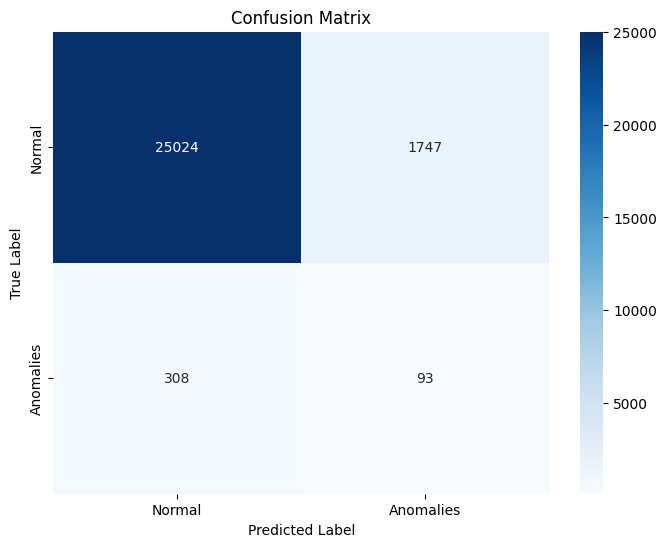


Generating SHAP explanations...


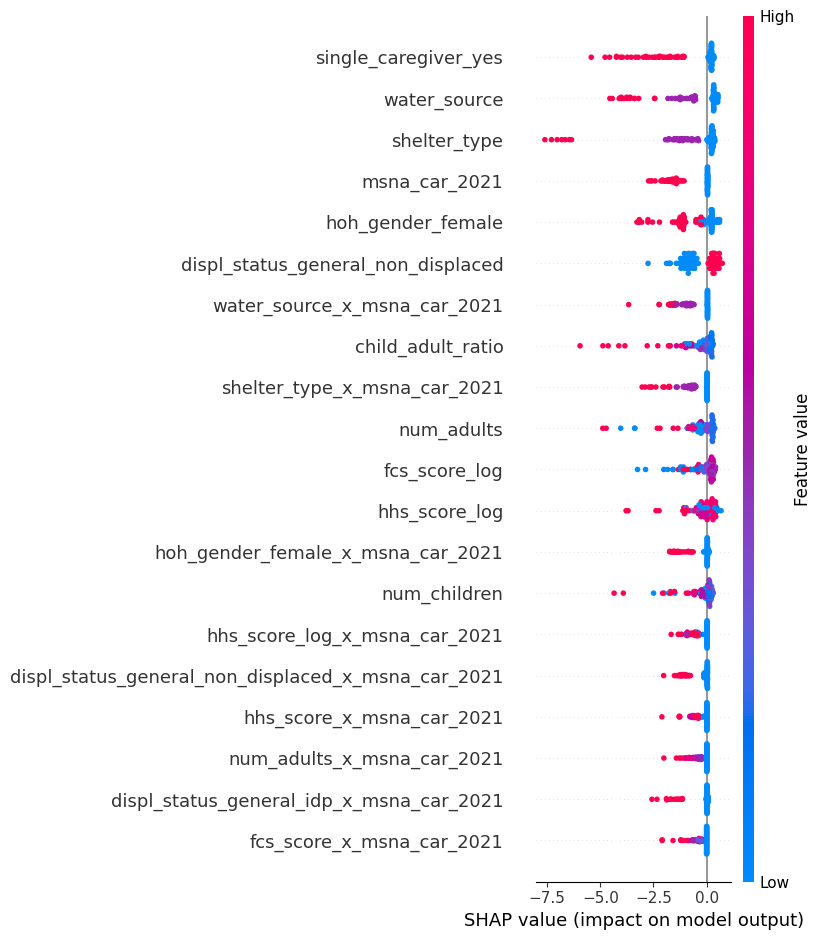

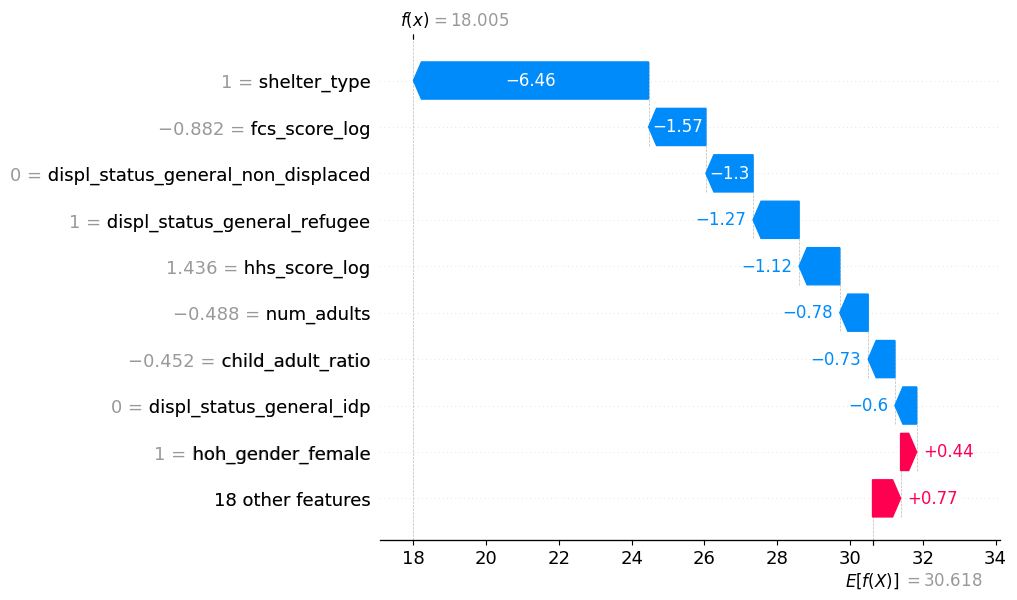

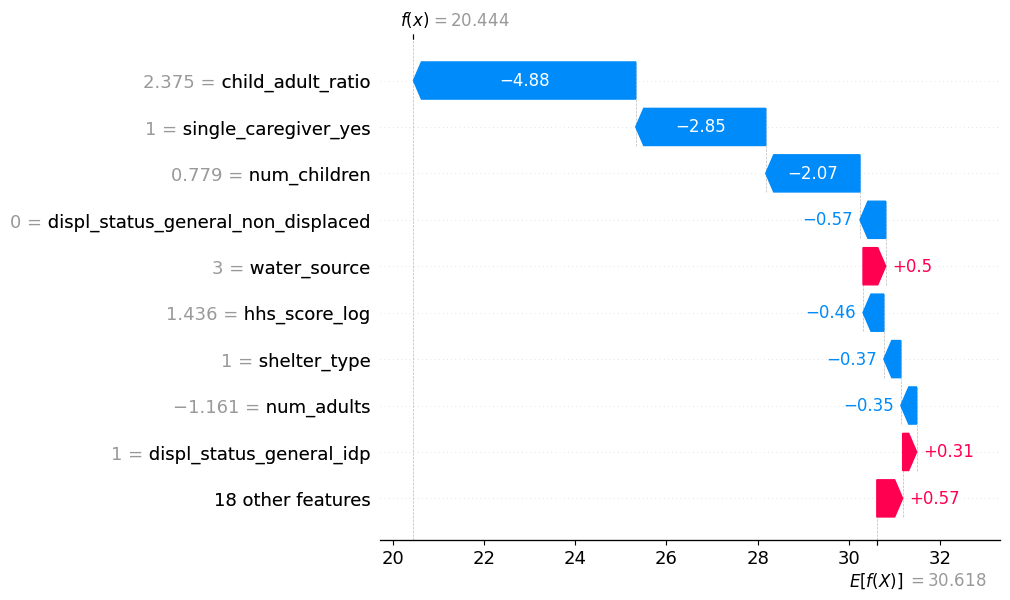

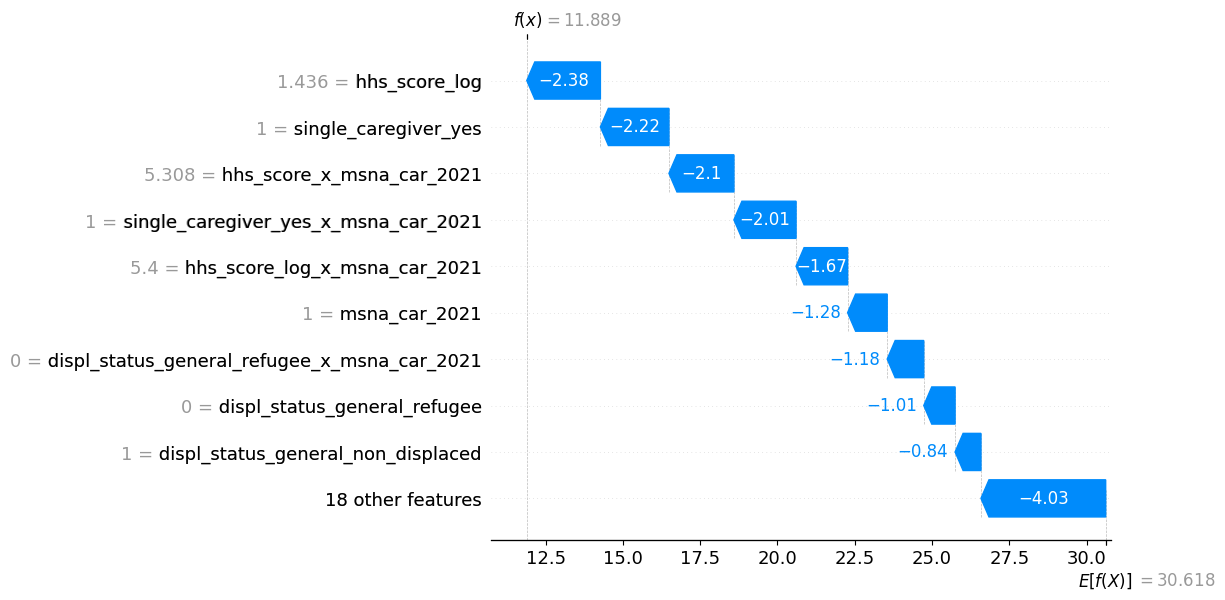

In [44]:
import pickle 
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

# Load best model and threshold
def load_best_model():
    with open('best_model.pkl', 'rb') as f:
        best_model, best_model_name, best_threshold = pickle.load(f)
    return best_model, best_model_name, best_threshold

# Load all models (for stacked model)
def load_all_models(filename='trained_models.pkl'):
    with open(filename, 'rb') as f:
        models = pickle.load(f)
    return models

# Load test data
def load_test_data():
    with open('X_test_selected.pkl', 'rb') as f:
        X_test = pickle.load(f)
    with open('y_test.pkl', 'rb') as f:
        y_test = pickle.load(f)
    return X_test, y_test

# Ensure test data has the same columns as training data
def align_test_data(X_test):
    # Ensure X_test is a DataFrame
    if not isinstance(X_test, pd.DataFrame):
        X_test = pd.DataFrame(X_test)

    # Assign column names to X_test if necessary
    if X_test.columns.isnull().any() or all(isinstance(col, int) for col in X_test.columns):
        with open('feature_names.pkl', 'rb') as f:
            feature_names = pickle.load(f)
        X_test.columns = feature_names
    return X_test

# Evaluate best model on test data and plot SHAP values
def evaluate_on_test(model, X_test, y_test, models=None, best_model_name='', best_threshold=None):
    is_stacked_model = (best_model_name == 'StackedModel')

    if is_stacked_model:
        print("\nEvaluating the Stacked Model...")

        # Get base models
        ocsvm = models['OneClassSVM']
        iso_forest = models['IsolationForest']

        # Get anomaly scores from base models
        ocsvm_scores = -ocsvm.decision_function(X_test).reshape(-1, 1)
        iso_forest_scores = -iso_forest.score_samples(X_test).reshape(-1, 1)

        # Stack the scores into meta-features
        meta_features = np.hstack((ocsvm_scores, iso_forest_scores))

        # Get anomaly scores from stacked model
        if hasattr(model, 'decision_function'):
            scores = -model.decision_function(meta_features)
        else:
            scores = -model.score_samples(meta_features)

        # Apply the threshold
        y_pred_binary = (scores >= best_threshold).astype(int)
    else:
        print("\nEvaluating the Base Model...")

        # Get anomaly scores
        if hasattr(model, 'decision_function'):
            scores = -model.decision_function(X_test)
        else:
            scores = -model.score_samples(X_test)

        # Apply the threshold
        y_pred_binary = (scores >= best_threshold).astype(int)

    # Print value counts after conversion
    print("\nPrediction value counts:")
    print(pd.Series(y_pred_binary).value_counts())

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_binary, digits=4))

    # Plot Confusion Matrix
    plot_confusion_matrix(y_test, y_pred_binary)

    # SHAP explanation focusing on anomalies
    if hasattr(model, 'decision_function') or is_stacked_model:
        plot_shap_values(model, X_test, y_pred_binary, models=models, is_stacked_model=is_stacked_model)

# Plot a confusion matrix using seaborn
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Normal', 'Anomalies'], yticklabels=['Normal', 'Anomalies'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix_plot.png', bbox_inches='tight')  # Export the confusion matrix
    plt.show()
    plt.close()

# Plot SHAP values with additional plots (beeswarm and waterfall)
def plot_shap_values(model, X_test, y_pred_binary, models=None, is_stacked_model=False):
    print("\nGenerating SHAP explanations...")

    # Focus on anomaly predictions
    anomaly_samples = X_test[y_pred_binary == 1]

    if anomaly_samples.empty:
        print("No anomalies detected. Skipping SHAP explanations.")
        return

    if anomaly_samples.shape[0] > 100:
        anomaly_samples = anomaly_samples.sample(n=100, random_state=42)

    if is_stacked_model:
        # Generate SHAP explanations for IsolationForest only
        print("\nGenerating SHAP explanations for IsolationForest...")
        iso_forest = models['IsolationForest']
        anomaly_samples_iso = anomaly_samples

        explainer_iso = shap.TreeExplainer(iso_forest)
        shap_values_iso = explainer_iso.shap_values(anomaly_samples_iso)

        # SHAP Beeswarm Plot for IsolationForest
        plt.figure()
        shap.summary_plot(shap_values_iso, anomaly_samples_iso, plot_type="dot", show=False)
        plt.savefig('shap_beeswarm_plot_isolation_forest.png', bbox_inches='tight')
        plt.show()
        plt.close()

        # SHAP Waterfall Plots for IsolationForest
        random_samples = anomaly_samples_iso.sample(n=3, random_state=42)
        for i in range(3):
            shap_explanation = shap.Explanation(values=shap_values_iso[i],
                                                base_values=explainer_iso.expected_value,
                                                data=random_samples.iloc[i],
                                                feature_names=random_samples.columns)
            plt.figure()
            shap.waterfall_plot(shap_explanation, show=False)
            plt.savefig(f'shap_waterfall_plot_isolation_forest_sample_{i+1}.png', bbox_inches='tight')
            plt.show()
            plt.close()

    else:
        # Initialize SHAP explainer
        if isinstance(model, IsolationForest):
            explainer = shap.TreeExplainer(model)
            anomaly_samples_aligned = anomaly_samples
        elif isinstance(model, OneClassSVM):
            # SHAP KernelExplainer for OneClassSVM (computationally intensive)
            print("\nGenerating SHAP explanations for OneClassSVM...")
            anomaly_samples_aligned = anomaly_samples

            # Use a small background sample for KernelExplainer
            background_samples = anomaly_samples_aligned.sample(n=50, random_state=42)
            explainer = shap.KernelExplainer(model.decision_function, background_samples)
        else:
            print("SHAP explanations not supported for this model.")
            return

        # Get SHAP values for the anomaly samples
        shap_values = explainer.shap_values(anomaly_samples_aligned)

        # SHAP Beeswarm Plot
        plt.figure()
        shap.summary_plot(shap_values, anomaly_samples_aligned, plot_type="dot", show=False)
        plt.savefig('shap_beeswarm_plot.png', bbox_inches='tight')
        plt.show()
        plt.close()

        # SHAP Waterfall Plots
        random_samples = anomaly_samples_aligned.sample(n=3, random_state=42)
        for i in range(3):
            shap_explanation = shap.Explanation(values=shap_values[i],
                                                base_values=explainer.expected_value,
                                                data=random_samples.iloc[i],
                                                feature_names=random_samples.columns)
            plt.figure()
            shap.waterfall_plot(shap_explanation, show=False)
            plt.savefig(f'shap_waterfall_plot_sample_{i+1}.png', bbox_inches='tight')
            plt.show()
            plt.close()

if __name__ == '__main__': 
    print("Loading the best model...")
    model, best_model_name, best_threshold = load_best_model()

    # Load all models if necessary (for stacked model)
    models = None
    if best_model_name == 'StackedModel':
        models = load_all_models()

    # Load the test set
    print("\nLoading test set...")
    X_test, y_test = load_test_data()

    # Align test data
    X_test = align_test_data(X_test)

    # Evaluate the best model on the test set
    evaluate_on_test(model, X_test, y_test, models=models, best_model_name=best_model_name, best_threshold=best_threshold)


## 12. Analysis

### Model Performance Summary

The dataset continues to exhibit a strong class imbalance, with anomalies constituting only **1.47%** of the test data (401 anomalies out of 27,172 samples).

#### Random Guessing Baseline:
- If the model were randomly guessing, we would expect around **1.47% precision** and **1.47% recall** for identifying anomalies due to the low occurrence of anomalies in the dataset.

#### Model Performance (based on results):
- **Precision for anomalies (Class 1)**: **5.05%**
  - This is significantly better than random guessing (~1.47%), but still low, indicating that the model struggles with false positives. When the model predicts anomalies, it is correct about **5.05%** of the time.
  
- **Recall for anomalies (Class 1)**: **23.19%**
  - The model identifies **23.19%** of the actual anomalies, meaning it detects approximately **1 out of every 4 anomalies**, which is better than random guessing but still leaves room for improvement.

#### Confusion Matrix:
- The model correctly predicted **25,024 normal cases** and **93 anomalies**.
- It misclassified **1,747 normal cases** as anomalies (false positives) and missed **308 anomalies** (false negatives).

#### Accuracy:
- The overall **accuracy** is **92.44%**, which appears high but is largely driven by the correct classification of the majority class (normal cases). This does not reflect strong anomaly detection performance.

#### Macro-Averaged and Weighted Metrics:
- The **macro-averaged precision, recall, and f1-score** give a more balanced view of the model's performance across both classes. The macro-average f1-score is **52.18%**, showing moderate performance overall.
- The **weighted-average f1-score** is high at **94.76%**, reflecting the model's strong performance on the majority class (normal cases), but this does not represent how well the model performs in detecting anomalies.

#### Conclusion:
- The model's **precision for anomalies (5.05%)** is an improvement over random guessing, but the model still produces a significant number of false positives.
- The **recall for anomalies (23.19%)** shows that the model misses more than 75% of the true anomalies, suggesting that further optimization is needed to improve its detection capabilities.
- The **accuracy of 92.44%** mainly reflects the model's performance on normal cases and does not indicate strong anomaly detection.
- The confusion matrix demonstrates that the model, while reasonably precise, still fails to detect many anomalies and produces false positives.

### SHAP Summary Plot Interpretation for Anomaly Detection

In this SHAP summary plot, the **SHAP TreeExplainer** was used to interpret the model’s predictions for **anomaly detection**. Here’s the detailed interpretation:

#### Notes:

1. **SHAP Values**:
   - **Negative SHAP values** (towards the left) indicate that the feature contributes to classifying an instance as an anomaly.
   - **Positive SHAP values** (towards the right) indicate that the feature contributes to classifying an instance as a normal case.

2. **Colors:** **Red dots** represent higher feature values, while **blue dots** represent lower feature values.

#### Feature Interpretation:

1. **Top Contributing Features**:
   - **single_caregiver_yes**:
     - A “yes” for single caregiver (red dots) strongly pushes the model towards predicting anomalies, as indicated by predominantly negative SHAP values.
   - **water_source**:
     - Higher values for water source (red dots) contribute to normal predictions, while lower values (blue dots) push the model towards predicting anomalies.
   - **shelter_type**:
     - Specific shelter types contribute significantly to anomaly detection, as reflected by the negative SHAP values.

2. **Mixed Features**:
   - **msna_car_2021**:
     - This feature shows both positive and negative SHAP contributions, indicating that its influence on the model's prediction depends on interactions with other features. Higher values (red) tend to push predictions towards normal cases, while lower values (blue) push towards anomalies.
   
3. **Non-displaced Status (displ_status_general_non_displaced)**:
   - **Higher values** of this feature (red dots) are associated with **normal cases**, as indicated by their positive SHAP values.
   - **Lower values** (blue dots) are associated with **anomalies**, as reflected by their negative SHAP values. In summary, being **displaced** increases the likelihood of the model predicting an anomaly, while being **non-displaced** is associated with normal predictions.

4. **Interaction Effects**:
   - **water_source_x_msna_car_2021**:
     - This feature shows mixed SHAP values, indicating an interaction effect. Depending on the interaction with other features, it can contribute to both anomaly and normal predictions.

5. **Neutral Features**:
   - **hhs_score_log** and **fcs_score_log**:
     - These features generally have SHAP values close to zero, meaning they do not have a strong influence on the model’s prediction for most instances.

#### Summary:
- **single_caregiver_yes**, **water_source**, and **shelter_type** are the top contributing features pushing the model to predict anomalies.
- **displ_status_general_non_displaced** contributes to predicting **normal** cases, with displaced individuals being more likely to be classified as anomalies.
- Some features show interaction effects, influencing both anomaly and normal predictions, depending on the context.

